# Coral-MTL Experiment Visual Analytics
This notebook assembles the complete figure suite described in `visualizations_ideas.md`, sourcing metrics and artifacts directly from the experiment outputs. All paths, configurations, and loaders are resolved through reusable utilities under `notebooks/utils/` to avoid hard-coded values.

In [1]:
from __future__ import annotations

import importlib
import json
import math
import os
import random
import sys
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Set, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from PIL import Image
from sklearn.calibration import calibration_curve
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import average_precision_score, precision_recall_curve

try:
    import umap
except ImportError:
    umap = None

try:
    from scipy.ndimage import distance_transform_edt
except ImportError:
    distance_transform_edt = None

try:
    from skimage.segmentation import find_boundaries
except ImportError:
    find_boundaries = None

from utils import metrics_loading as metrics_loading_module
metrics_loading = importlib.reload(metrics_loading_module)

from coral_mtl.ExperimentFactory import ExperimentFactory
from utils.config_utils import build_inference_ready_config
from utils.project_paths import ensure_output_dirs_exist, get_project_root
from utils.visualization_settings import get_visualization_settings
from utils.experiment_registry import ExperimentMetadata, discover_experiments
from utils.metrics_loading import (
    extract_per_class_rows,
    extract_task_summary,
    load_confusion_matrices,
    load_history_frame,
    load_test_metrics,
    load_advanced_metrics,
 )
from utils.inference_utils import TaskInferenceResult, collect_task_predictions
from utils.color_maps import build_index_color_map
from utils.label_utils import get_grouped_label_names, get_ungrouped_label_names


In [2]:
project_root = get_project_root()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 9,
})

random.seed(42)
np.random.seed(42)

output_dirs = ensure_output_dirs_exist()
settings = get_visualization_settings()
output_dirs

{'poster': WindowsPath('C:/Users/20232788/Desktop/Year3/dbl_capstone/latex/Poster_Data_shallange/Result-figures'),
 'report': WindowsPath('C:/Users/20232788/Desktop/Year3/dbl_capstone/latex/Methodology/Result-figures')}

In [3]:
all_experiments = discover_experiments()
target_tokens = {
    "baseline": "coral_baseline_b2_run",
    "mtl_focused": "coral_mtl_b2_focused_run",
    "mtl_holistic": "coral_mtl_b2_holistic_run",
}
experiments: Dict[str, ExperimentMetadata] = {}
for meta in all_experiments:
    for key, token in target_tokens.items():
        if token in meta.name:
            experiments[key] = meta

missing = [k for k in target_tokens if k not in experiments]
if missing:
    raise RuntimeError(f"Missing expected experiments: {missing}")

summary_rows = []
for key, meta in experiments.items():
    available_artifacts = sorted(meta.artifacts.keys())
    summary_rows.append({
        "alias": key,
        "experiment": meta.name,
        "config": str(meta.config_path) if meta.config_path else "<unknown>",
        "artifacts": ", ".join(available_artifacts),
    })
summary_frame = pd.DataFrame(summary_rows)
summary_frame

alias                                      experiment  \
0      baseline      baseline_comparisons/coral_baseline_b2_run   
1   mtl_focused   baseline_comparisons/coral_mtl_b2_focused_run   
2  mtl_holistic  baseline_comparisons/coral_mtl_b2_holistic_run   

                                              config  \
0  C:\Users\20232788\Desktop\Year3\dbl_capstone\c...   
1  C:\Users\20232788\Desktop\Year3\dbl_capstone\c...   
2  C:\Users\20232788\Desktop\Year3\dbl_capstone\c...   

                                           artifacts  
0  advanced_metrics, checkpoint, history, loss_di...  
1  advanced_metrics, checkpoint, history, loss_di...  
2  advanced_metrics, checkpoint, history, loss_di...

In [4]:
def export_figure(fig: plt.Figure, filename: str, consumers: Iterable[str] = ("poster", "report"), formats: Iterable[str] = ("png",)) -> List[Path]:
    """Save a figure into the configured export directories."""
    exported_paths: List[Path] = []
    for consumer in consumers:
        base_dir = output_dirs.get(consumer)
        if base_dir is None:
            continue
        for ext in formats:
            export_path = base_dir / f"{filename}.{ext}"
            export_path.parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(export_path, bbox_inches="tight")
            exported_paths.append(export_path)
    return exported_paths


def load_history_metrics(metadata: ExperimentMetadata) -> pd.DataFrame:
    """Return a wide DataFrame of history metrics keyed by epoch."""
    tidy = load_history_frame(metadata)
    wide = tidy.pivot(index="epoch", columns="metric", values="value").sort_index()
    epoch_values = wide.index.astype(int) + 1
    wide.index = epoch_values
    if "epoch" in wide.columns:
        wide = wide.rename(columns={"epoch": "metric_epoch"})
    wide.insert(0, "epoch", epoch_values)
    wide.columns.name = None
    return wide


def extract_metric_series(history: pd.DataFrame, metric_key: str) -> Optional[pd.Series]:
    """Safely extract a metric series if it exists."""
    if metric_key not in history.columns:
        return None
    return history[["epoch", metric_key]].rename(columns={metric_key: "value"})

In [5]:
def normalize_confusion(matrix: np.ndarray, mode: str = "recall") -> np.ndarray:
    """Normalize a confusion matrix along the specified axis."""
    array = np.asarray(matrix, dtype=np.float64)
    if array.ndim != 2:
        raise ValueError("Confusion matrix must be two-dimensional.")
    if array.size == 0:
        return array
    if mode not in {"recall", "precision"}:
        raise ValueError(f"Unsupported normalization mode: {mode}")
    axis = 1 if mode == "recall" else 0
    denominators = array.sum(axis=axis, keepdims=True)
    denominators = np.where(denominators == 0, 1.0, denominators)
    return array / denominators


def summarize_predictions(result: TaskInferenceResult) -> pd.DataFrame:
    """Return a DataFrame summarizing max-confidence predictions for a task."""
    probabilities = result.probabilities
    targets = result.targets
    if probabilities.ndim != 2:
        raise ValueError("Probabilities array must be 2D (pixels × classes).")
    predicted = probabilities.argmax(axis=1)
    max_confidence = probabilities.max(axis=1)
    frame = pd.DataFrame({
        "target": targets,
        "predicted": predicted,
        "max_confidence": max_confidence,
    })
    frame["correct"] = (frame["predicted"] == frame["target"]).astype(np.float32)
    return frame


def compute_per_image_error_rates(cms_path: Path) -> pd.DataFrame:
    """Compute per-image error rates for each task from a confusion JSONL file."""
    rows: List[Dict[str, object]] = []
    if cms_path is None or not cms_path.exists():
        return pd.DataFrame(rows)
    with cms_path.open("r", encoding="utf-8") as handle:
        for line in handle:
            if not line.strip():
                continue
            payload = json.loads(line)
            image_id = payload.get("image_id")
            per_image = payload.get("per_image_metrics", {})
            confusions = payload.get("confusion_matrices", {})
            for task_name, metrics in per_image.items():
                confusion = confusions.get(task_name)
                if confusion is None:
                    continue
                confusion_array = np.asarray(confusion, dtype=np.float64)
                total = confusion_array.sum()
                if total <= 0:
                    continue
                correct = np.trace(confusion_array)
                error_rate = 1.0 - (correct / total)
                rows.append({
                    "image_id": image_id,
                    "task": task_name,
                    "error_rate": float(error_rate),
                    "num_pixels": metrics.get("num_pixels"),
                    "mIoU": metrics.get("mIoU"),
                })
    return pd.DataFrame(rows)


def select_top_genus_images(cms_path: Path, top_k: int, unlabeled_index: int = 0) -> pd.DataFrame:
    """Return the top-K genus records (with coral present) sorted by mIoU.
    
    If top_k == 0, return the full dataframe sorted by mIoU descending.
    """
    records: List[Dict[str, object]] = []
    if cms_path is None or not cms_path.exists():
        return pd.DataFrame(records)
    with cms_path.open("r", encoding="utf-8") as handle:
        for line in handle:
            if not line.strip():
                continue
            payload = json.loads(line)
            confusion = payload.get("confusion_matrices", {}).get("genus")
            metrics = payload.get("per_image_metrics", {}).get("genus")
            image_id = payload.get("image_id")
            if confusion is None or metrics is None or image_id is None:
                continue
            confusion_array = np.asarray(confusion, dtype=np.int64)
            if confusion_array.ndim != 2 or confusion_array.shape[0] <= unlabeled_index:
                continue
            coral_pixels = int(confusion_array[unlabeled_index + 1 :].sum())
            if coral_pixels <= 0:
                continue
            mIoU = metrics.get("mIoU")
            if mIoU is None:
                continue
            records.append({
                "image_id": str(image_id),
                "mIoU": float(mIoU),
                "coral_pixels": coral_pixels,
                "total_pixels": int(confusion_array.sum()),
            })
    frame = pd.DataFrame(records)
    if frame.empty:
        return frame
    frame = frame.sort_values("mIoU", ascending=False).reset_index(drop=True)
    if top_k == 0:
        return frame
    return frame.head(top_k).reset_index(drop=True)

In [6]:
display_names = {
    "baseline": "Baseline SegFormer",
    "mtl_focused": "MTL Focused",
    "mtl_holistic": "MTL Holistic",
}
palette = {
    "baseline": "#4e79a7",
    "mtl_focused": "#f28e2b",
    "mtl_holistic": "#e15759",
}
model_palette = {display_names[key]: color for key, color in palette.items()}

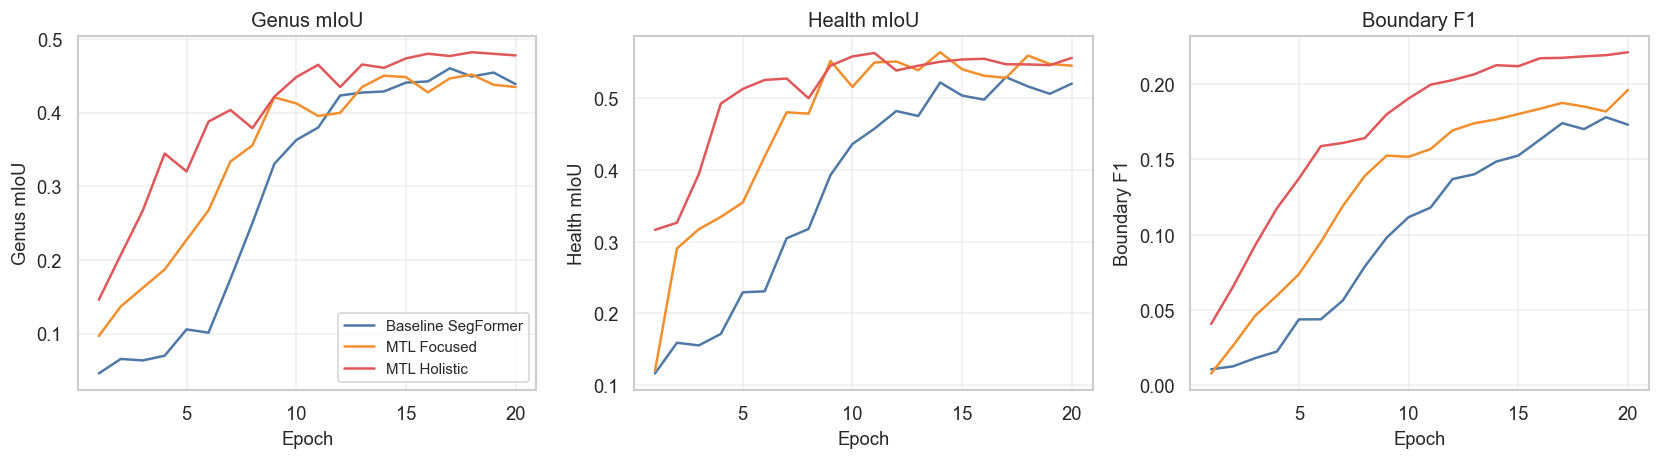

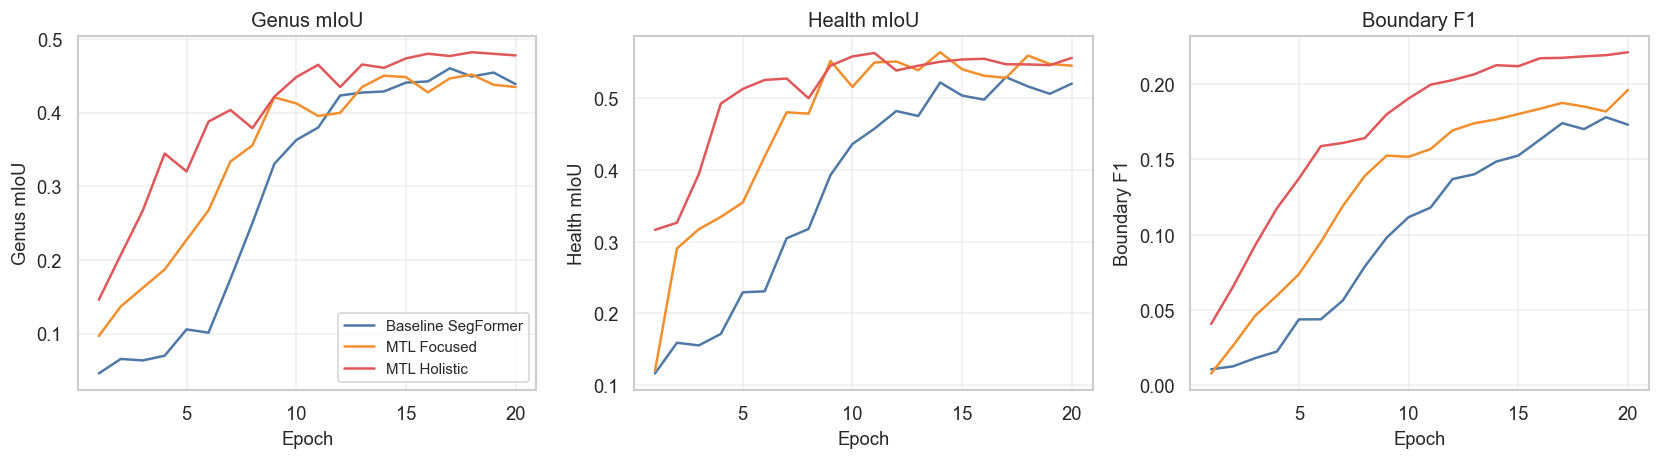

In [7]:
history_cache = {alias: load_history_metrics(meta) for alias, meta in experiments.items()}
history_metrics = [
    ("tasks.genus.grouped.mIoU", "Genus mIoU"),
    ("tasks.health.grouped.mIoU", "Health mIoU"),
    ("global.Boundary_F1", "Boundary F1"),
 ]

fig, axes = plt.subplots(1, len(history_metrics), figsize=(14, 4), sharex=True)
for ax, (metric_key, label) in zip(axes, history_metrics):
    for alias, history in history_cache.items():
        series = extract_metric_series(history, metric_key)
        if series is None:
            continue
        ax.plot(series["epoch"], series["value"], label=display_names[alias], color=palette[alias])
    ax.set_xlabel("Epoch")
    ax.set_ylabel(label)
    ax.grid(True, alpha=0.3)
    ax.set_title(label)
axes[0].legend(loc="lower right")
fig.tight_layout()
#training_curve_paths = export_figure(fig, "training_progress_3models")
fig

C:\Users\20232788\AppData\Local\Temp\ipykernel_22128\504026155.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha="right", fontsize=8)


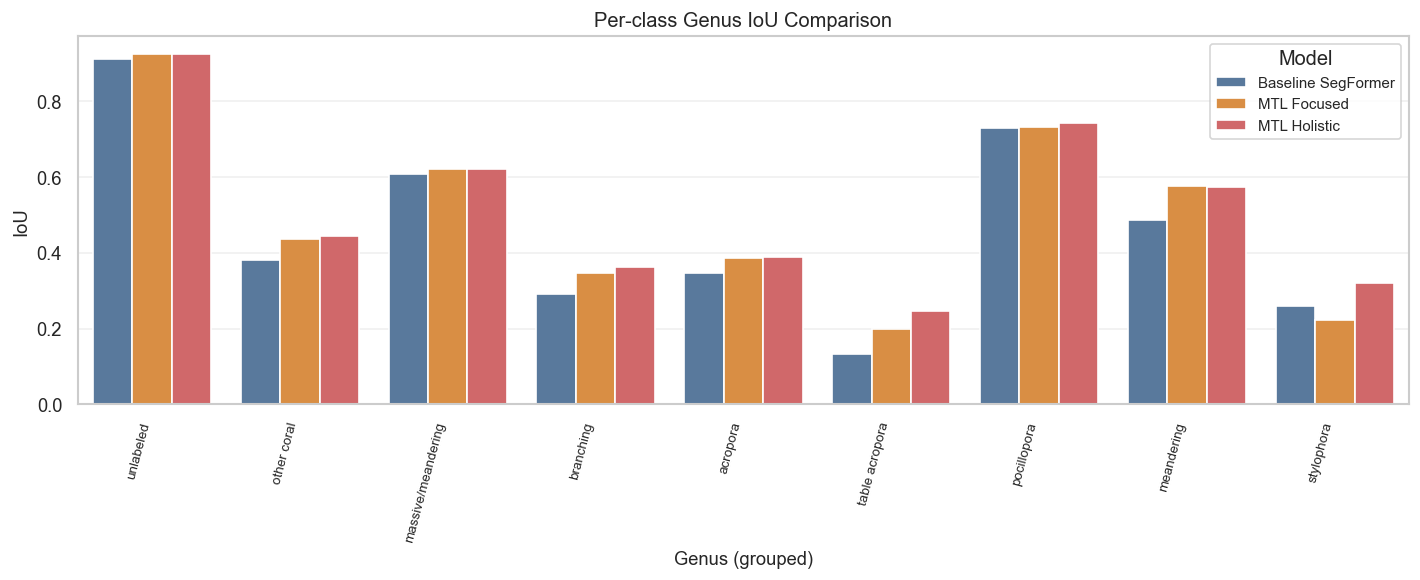

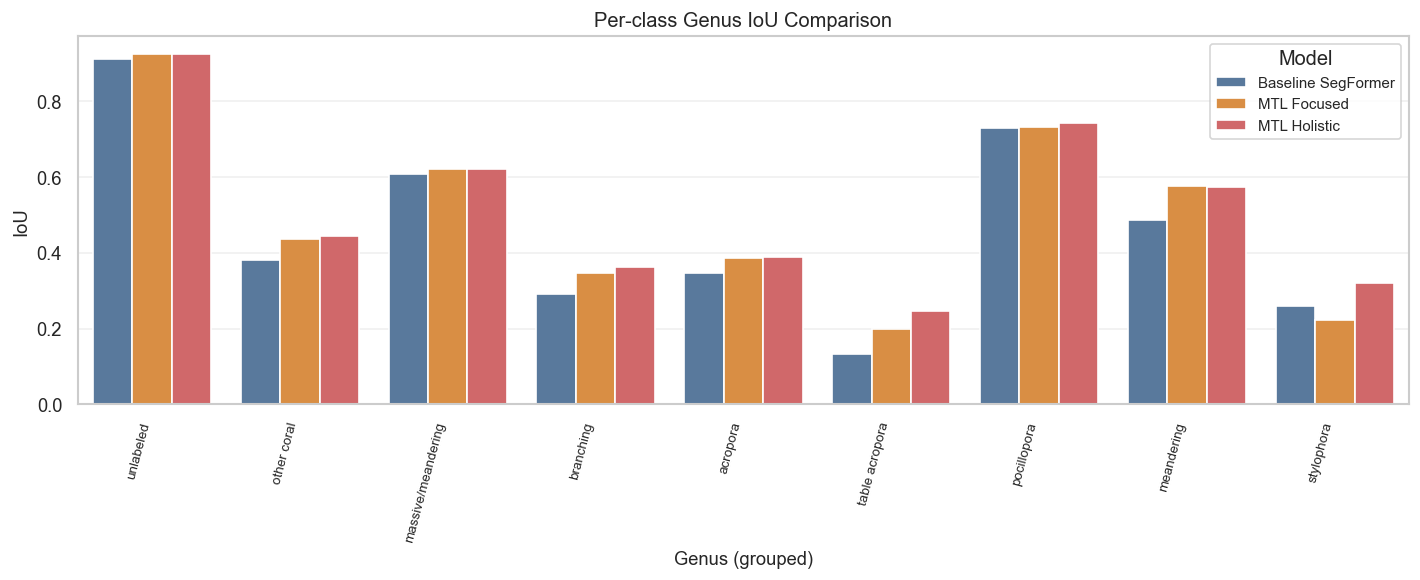

In [8]:
per_class_frames = []
for alias, meta in experiments.items():
    metrics_dict = load_test_metrics(meta)
    frame = extract_per_class_rows(metrics_dict, task="genus", level="grouped")
    if frame.empty:
        frame = extract_per_class_rows(metrics_dict, task="genus", level="ungrouped")
    if frame.empty:
        continue
    frame["Model"] = display_names[alias]
    frame["IoU"] = frame.get("IoU", frame.get("mIoU"))
    per_class_frames.append(frame[["Model", "class_name", "IoU"]])

per_class_df = pd.concat(per_class_frames, ignore_index=True)

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=per_class_df, x="class_name", y="IoU", hue="Model", palette=model_palette, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha="right", fontsize=8)
ax.set_xlabel("Genus (grouped)")
ax.set_ylabel("IoU")
ax.set_title("Per-class Genus IoU Comparison")
ax.grid(True, axis="y", alpha=0.3)
fig.tight_layout()
#per_class_paths = export_figure(fig, "per_class_iou_bars")
fig

In [9]:
tasks_for_inference = ["genus", "health"]
inference_results: Dict[Tuple[str, str], TaskInferenceResult] = {}
qualitative_panels: Dict[str, List[Dict[str, np.ndarray]]] = {}
config, fallback_used = build_inference_ready_config(Path(meta.config_path))

# Only select top_k images if full test dataset (with test_cms.jsonl) is available
# If using fallback tests dataset, we'll use whatever images are available
holistic_top_frame = pd.DataFrame()
holistic_top_ids: Optional[List[str]] = None
holistic_uses_fallback = False
holistic_meta = experiments.get("mtl_holistic")
if holistic_meta is not None:
    cms_path = holistic_meta.artifacts.get("test_cms")
    # Only compute top_k if test_cms exists (meaning full test dataset is available)
    if cms_path is not None and cms_path.exists() and not fallback_used:
        holistic_top_frame = select_top_genus_images(cms_path, 0)
        if not holistic_top_frame.empty:
            holistic_top_ids = holistic_top_frame["image_id"].tolist()
            holistic_top_ids = holistic_top_ids[:settings.qualitative_samples]
            print(f"[info] Using top-{len(holistic_top_ids)} genus images from full test dataset for mtl_holistic")
    else:
        print("[warn] test_cms.jsonl not found or full dataset not available - will use available images from fallback dataset")
        holistic_uses_fallback = True

for alias, meta in experiments.items():
    panels: List[Dict[str, np.ndarray]] = []
    for task_name in tasks_for_inference:
        attempt_kwargs: Dict[str, object] = {}
        # Only use target_image_ids if we have them (i.e., full test dataset is available)
        if holistic_top_ids:
            attempt_kwargs["target_image_ids"] = holistic_top_ids
        try:
            result = collect_task_predictions(meta, task_name, settings, **attempt_kwargs)
        except Exception as exc:
            if attempt_kwargs:
                print(f"[warn] Targeted inference failed for {alias}-{task_name}: {exc}. Falling back to full dataset.")
                try:
                    result = collect_task_predictions(meta, task_name, settings)
                except Exception as fallback_exc:
                    print(f"[warn] Unable to collect predictions for {alias}-{task_name}: {fallback_exc}")
                    continue
            else:
                print(f"[warn] Unable to collect predictions for {alias}-{task_name}: {exc}")
                continue
        if alias == "mtl_holistic" and task_name == "genus" and holistic_top_ids:
            missing_ids = sorted(set(holistic_top_ids) - set(result.image_ids))
            if missing_ids:
                print(f"[warn] Missing requested images for {alias}-{task_name}: {missing_ids}")
        inference_results[(alias, task_name)] = result
        panels.extend(result.image_panels)
    qualitative_panels[alias] = panels

holistic_top_frame if not holistic_top_frame.empty else len(inference_results)

[info] Using top-2 genus images from full test dataset for mtl_holistic
--- Resolving relative paths from root: C:\Users\20232788\Desktop\Year3\dbl_capstone ---
Resolved task_definitions_path: configs/task_definitions.yaml -> C:\Users\20232788\Desktop\Year3\dbl_capstone\configs\task_definitions.yaml
Initialized TaskSplitter with 7 tasks and a unified global space of 40 classes.
BaseTaskSplitter created a flattened training space of 40 classes.
--- Building model of type: SegFormerBaseline ---


c:\Users\20232788\Desktop\Year3\dbl_capstone\notebooks\utils\inference_utils.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, ma

--- Building dataloaders ---
Loading dataset from local file paths for split 'train'.
Loading 'train' split from prioritized PDS path: C:\Users\20232788\Desktop\Year3\dbl_capstone\tests\dataset\processed\pds_patches
Successfully loaded 4 samples for split 'train'.
Loading dataset from local file paths for split 'validation'.
Loading 'validation' split from data_root_path: C:\Users\20232788\Desktop\Year3\dbl_capstone\dataset\coralscapes
Successfully loaded 166 samples for split 'validation'.
[INFO] No target images found in validation split, skipping filter: No matching samples found for target image IDs: ['site23_000053_018750_leftImg8bit.png', 'site23_000084_009290_leftImg8bit.png']
Loading dataset from local file paths for split 'test'.
Loading 'test' split from data_root_path: C:\Users\20232788\Desktop\Year3\dbl_capstone\dataset\coralscapes
Successfully loaded 392 samples for split 'test'.
Filtered test dataset from 392 to 2 samples matching target IDs.
--- Resolving relative paths 

image_id      mIoU  coral_pixels  \
0     site23_000053_018750_leftImg8bit.png  0.303085        828283   
1     site23_000084_009290_leftImg8bit.png  0.297341        916524   
2     site23_000065_018601_leftImg8bit.png  0.287238        526345   
3     site23_000019_016483_leftImg8bit.png  0.286998        557269   
4     site23_000003_001400_leftImg8bit.png  0.255729        763695   
...                                    ...       ...           ...   
1054  site34_000008_001393_leftImg8bit.png  0.000009         84576   
1055   site1_000008_001303_leftImg8bit.png  0.000000          6159   
1056  site22_000072_001861_leftImg8bit.png  0.000000          7346   
1057   site1_000007_000584_leftImg8bit.png  0.000000         41301   
1058  site26_000033_019465_leftImg8bit.png  0.000000          8599   

      total_pixels  
0          2097152  
1          2097152  
2          2097152  
3          2097152  
4          2097152  
...            ...  
1054       2097152  
1055       2097152  
1056       2097152  
1057       2097152  
1058       2097152  

[1059 rows x 4 columns]

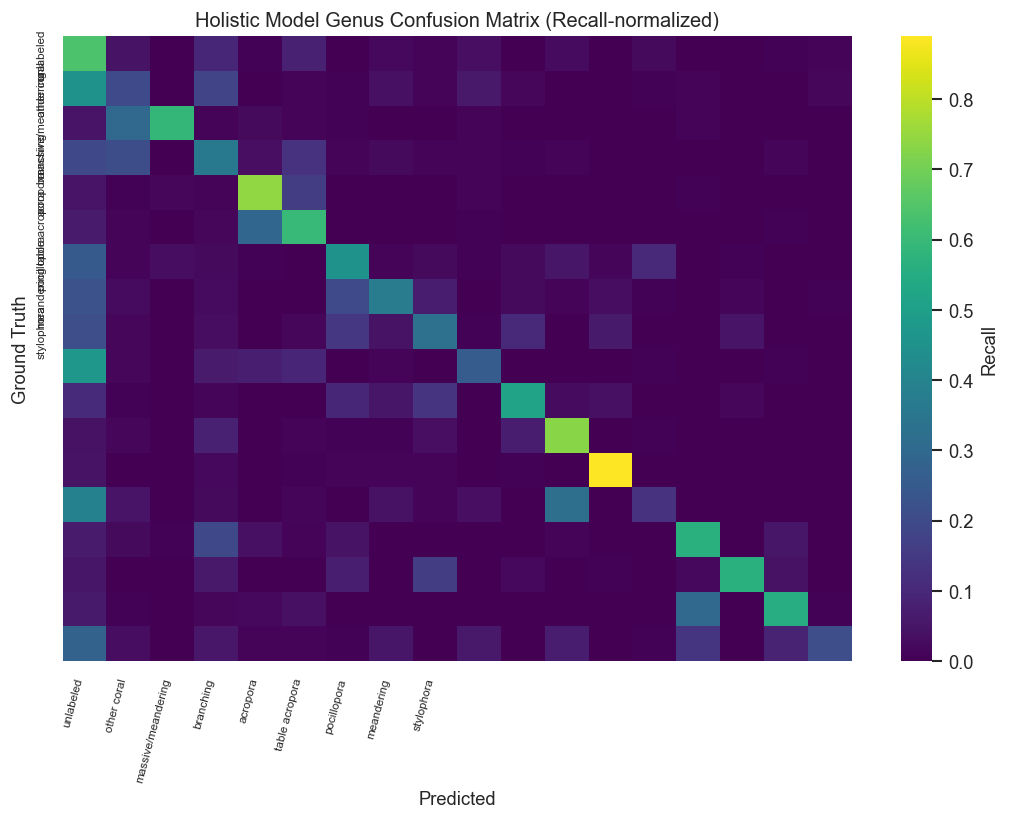

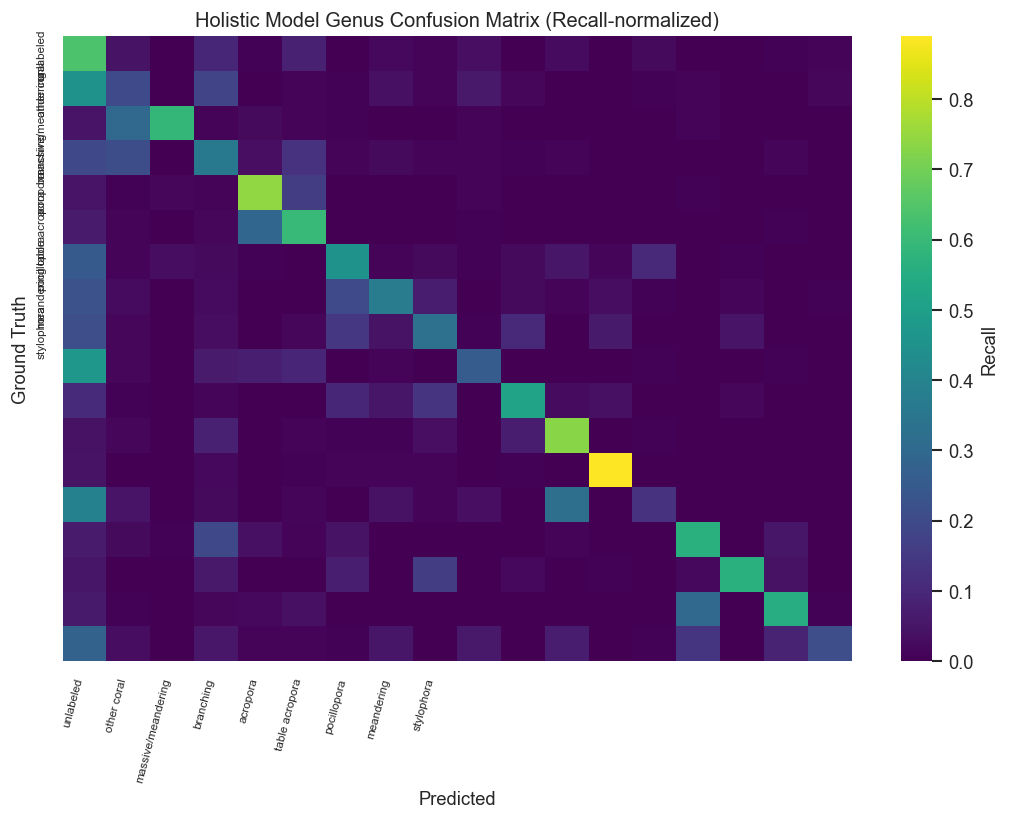

In [10]:
holistic_meta = experiments["mtl_holistic"]
holistic_confusions = load_confusion_matrices(holistic_meta)
genus_cm = holistic_confusions.get("genus")
if genus_cm is None:
    raise RuntimeError("Genus confusion matrix unavailable for holistic model.")

genus_norm = normalize_confusion(genus_cm, mode="recall")
label_names = inference_results[("mtl_holistic", "genus")].label_names
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(genus_norm, cmap="viridis", ax=ax, cbar_kws={"label": "Recall"})
ax.set_xticks(np.arange(len(label_names)) + 0.5)
ax.set_xticklabels(label_names, rotation=75, ha="right", fontsize=7)
ax.set_yticks(np.arange(len(label_names)) + 0.5)
ax.set_yticklabels(label_names, fontsize=7)
ax.set_xlabel("Predicted")
ax.set_ylabel("Ground Truth")
ax.set_title("Holistic Model Genus Confusion Matrix (Recall-normalized)")
fig.tight_layout()
#confusion_paths = export_figure(fig, "confusion_genus_holistic")
fig

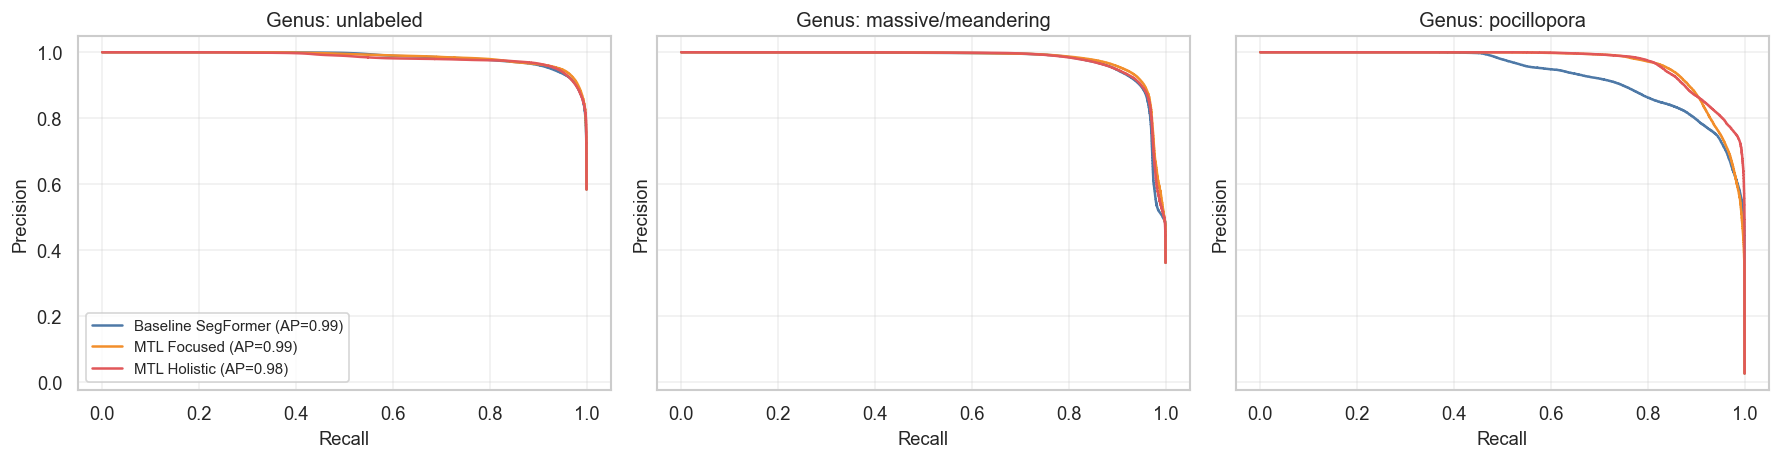

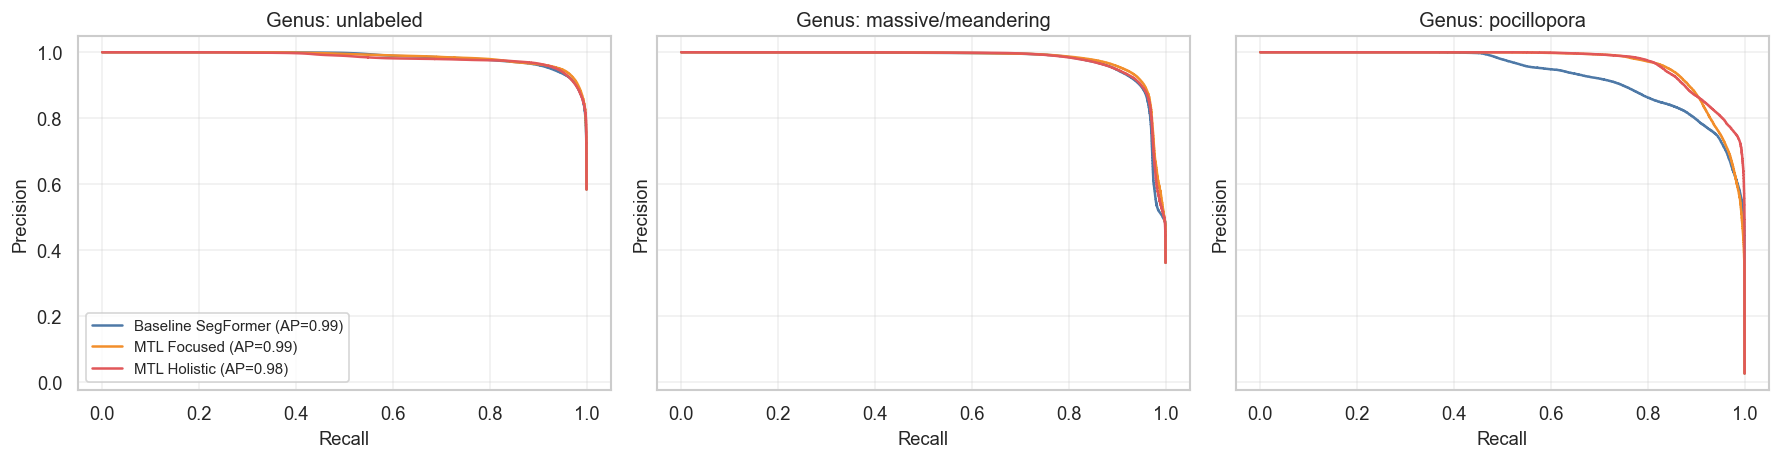

In [11]:
selected_alias_for_classes = "mtl_holistic"
reference_result = inference_results[(selected_alias_for_classes, "genus")]
class_counts = np.bincount(reference_result.targets, minlength=len(reference_result.label_names))
top_class_indices = class_counts.argsort()[::-1][:3]

fig, axes = plt.subplots(1, len(top_class_indices), figsize=(15, 4), sharey=True)
for ax, class_idx in zip(axes, top_class_indices):
    class_name = reference_result.label_names[class_idx]
    for alias in experiments.keys():
        result = inference_results.get((alias, "genus"))
        if result is None:
            continue
        y_true = (result.targets == class_idx).astype(np.int32)
        if y_true.sum() == 0:
            continue
        y_scores = result.probabilities[:, class_idx]
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ap = average_precision_score(y_true, y_scores)
        ax.plot(recall, precision, label=f"{display_names[alias]} (AP={ap:.2f})", color=palette[alias])
    ax.set_title(f"Genus: {class_name}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.grid(True, alpha=0.3)
axes[0].legend(loc="lower left")
fig.tight_layout()
#pr_paths = export_figure(fig, "pr_curves_genus_top3")
fig

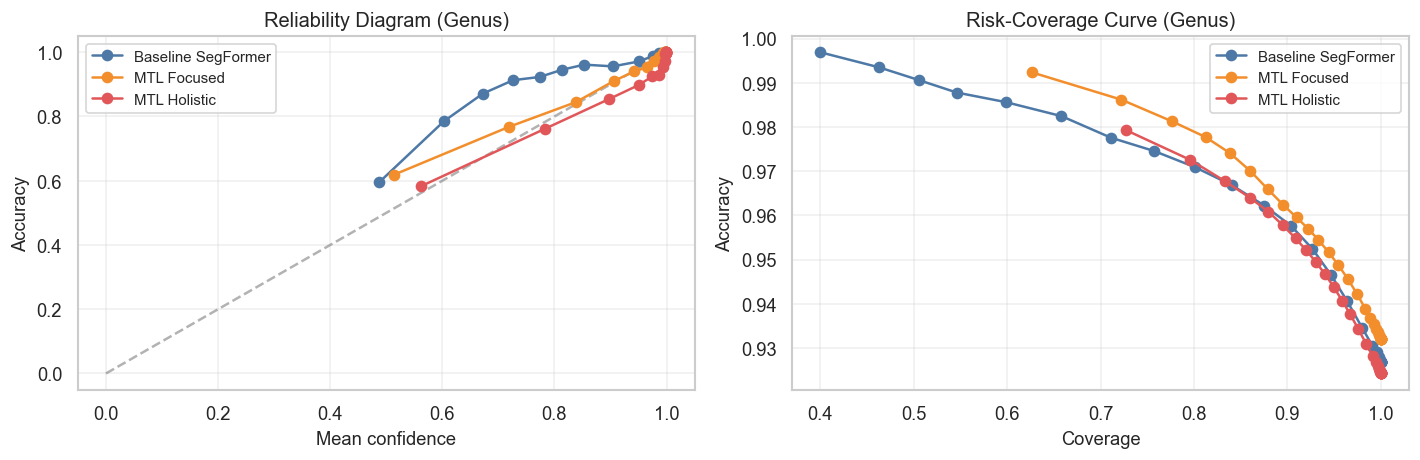

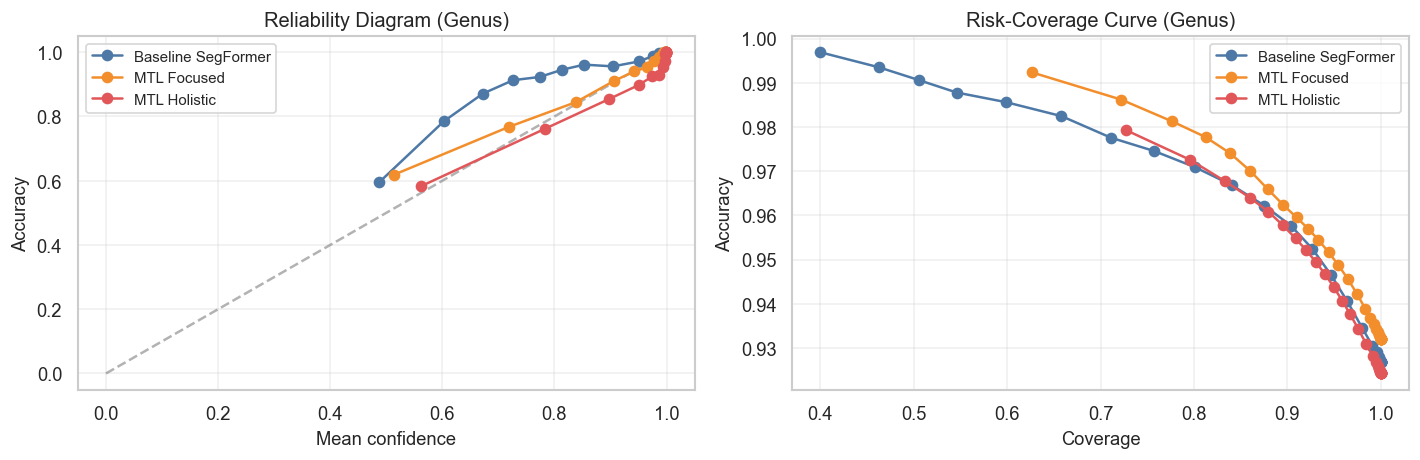

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
reliability_ax, risk_ax = axes

reliability_ax.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.6)
for alias in experiments.keys():
    result = inference_results.get((alias, "genus"))
    if result is None:
        continue
    summary = summarize_predictions(result)
    frac_pos, mean_pred = calibration_curve(summary["correct"], summary["max_confidence"], n_bins=settings.reliability_bins, strategy="quantile")
    reliability_ax.plot(mean_pred, frac_pos, marker="o", label=display_names[alias], color=palette[alias])

thresholds = np.linspace(0.0, 1.0, 31)
for alias in experiments.keys():
    result = inference_results.get((alias, "genus"))
    if result is None:
        continue
    summary = summarize_predictions(result)
    cov = []
    acc = []
    for t in thresholds:
        mask = summary["max_confidence"] >= t
        coverage = mask.mean()
        if coverage == 0:
            acc.append(np.nan)
        else:
            acc.append(summary["correct"][mask].mean())
        cov.append(coverage)
    risk_ax.plot(cov, acc, marker="o", label=display_names[alias], color=palette[alias])

reliability_ax.set_xlabel("Mean confidence")
reliability_ax.set_ylabel("Accuracy")
reliability_ax.set_title("Reliability Diagram (Genus)")
risk_ax.set_xlabel("Coverage")
risk_ax.set_ylabel("Accuracy")
risk_ax.set_title("Risk-Coverage Curve (Genus)")
reliability_ax.legend(loc="upper left")
risk_ax.legend(loc="upper right")
for ax in axes:
    ax.grid(True, alpha=0.3)
fig.tight_layout()
#reliability_paths = export_figure(fig, "reliability_diagram_genus")
fig

In [13]:
def build_color_lut(label_names: List[str], cmap_name: str = "tab20") -> np.ndarray:
    color_map = build_index_color_map(label_names, cmap_name=cmap_name)
    lut = np.zeros((len(label_names), 3), dtype=np.float32)
    for idx in range(len(label_names)):
        lut[idx] = color_map[idx]
    return lut

def mask_to_rgb(mask: np.ndarray, lut: np.ndarray) -> np.ndarray:
    mask = np.clip(mask.astype(np.int64), 0, len(lut) - 1)
    colored = lut[mask]
    return np.clip(colored, 0.0, 1.0)

{'baseline': <Figure size 1920x960 with 8 Axes>,
 'mtl_focused': <Figure size 1920x960 with 8 Axes>,
 'mtl_holistic': <Figure size 1920x960 with 8 Axes>}

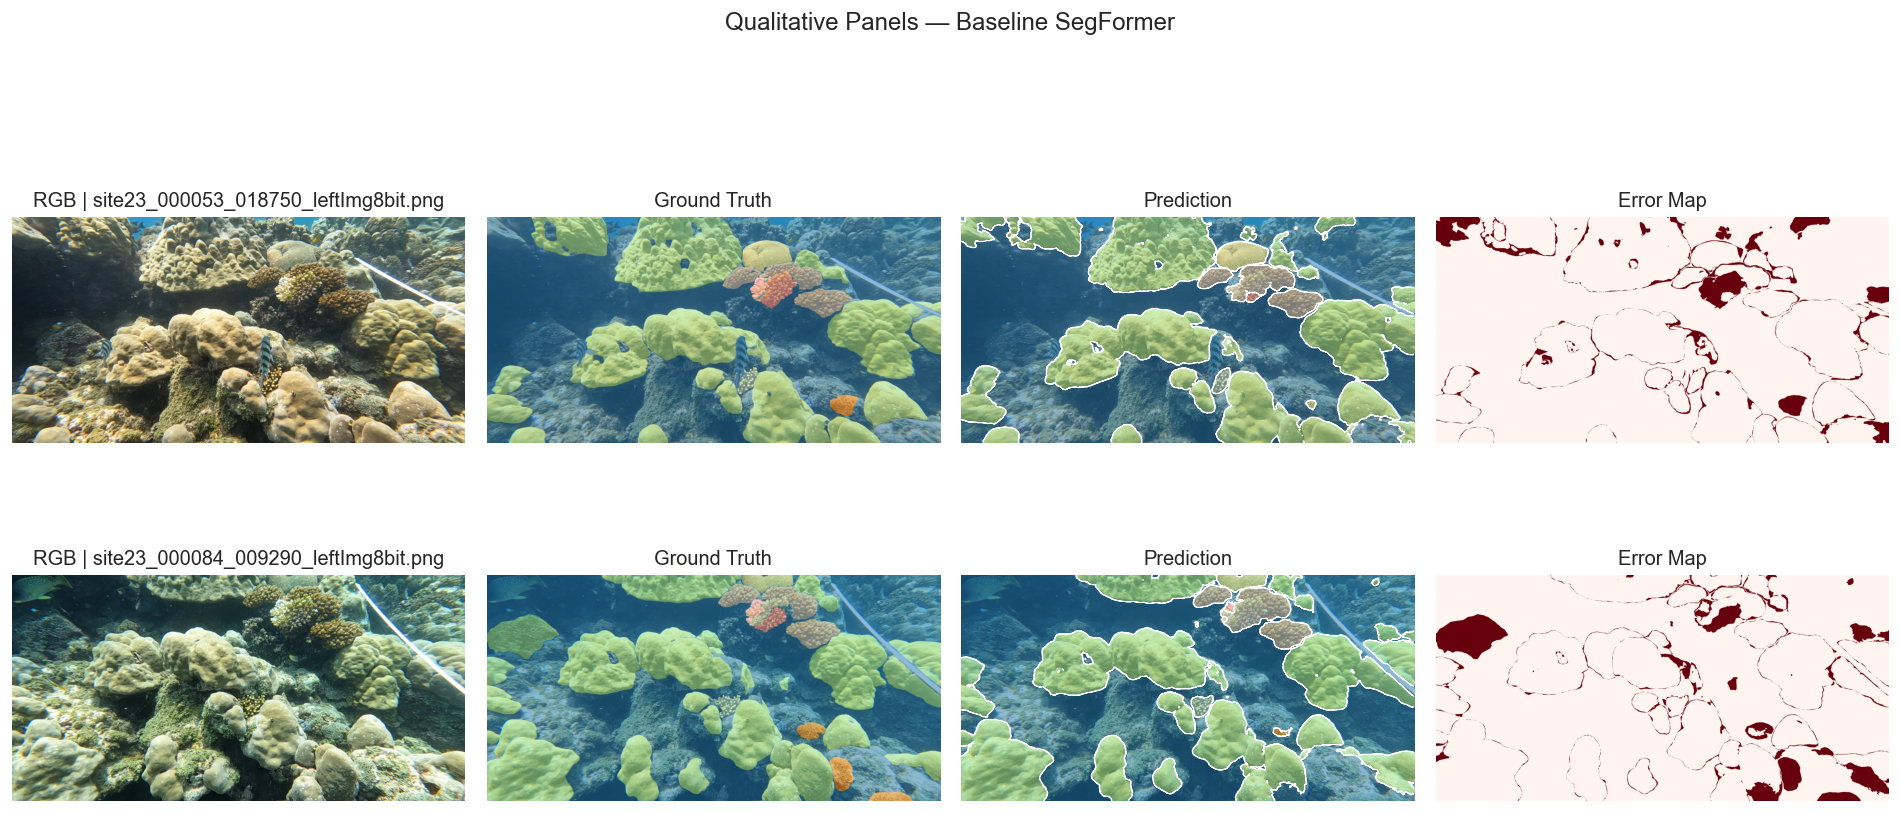

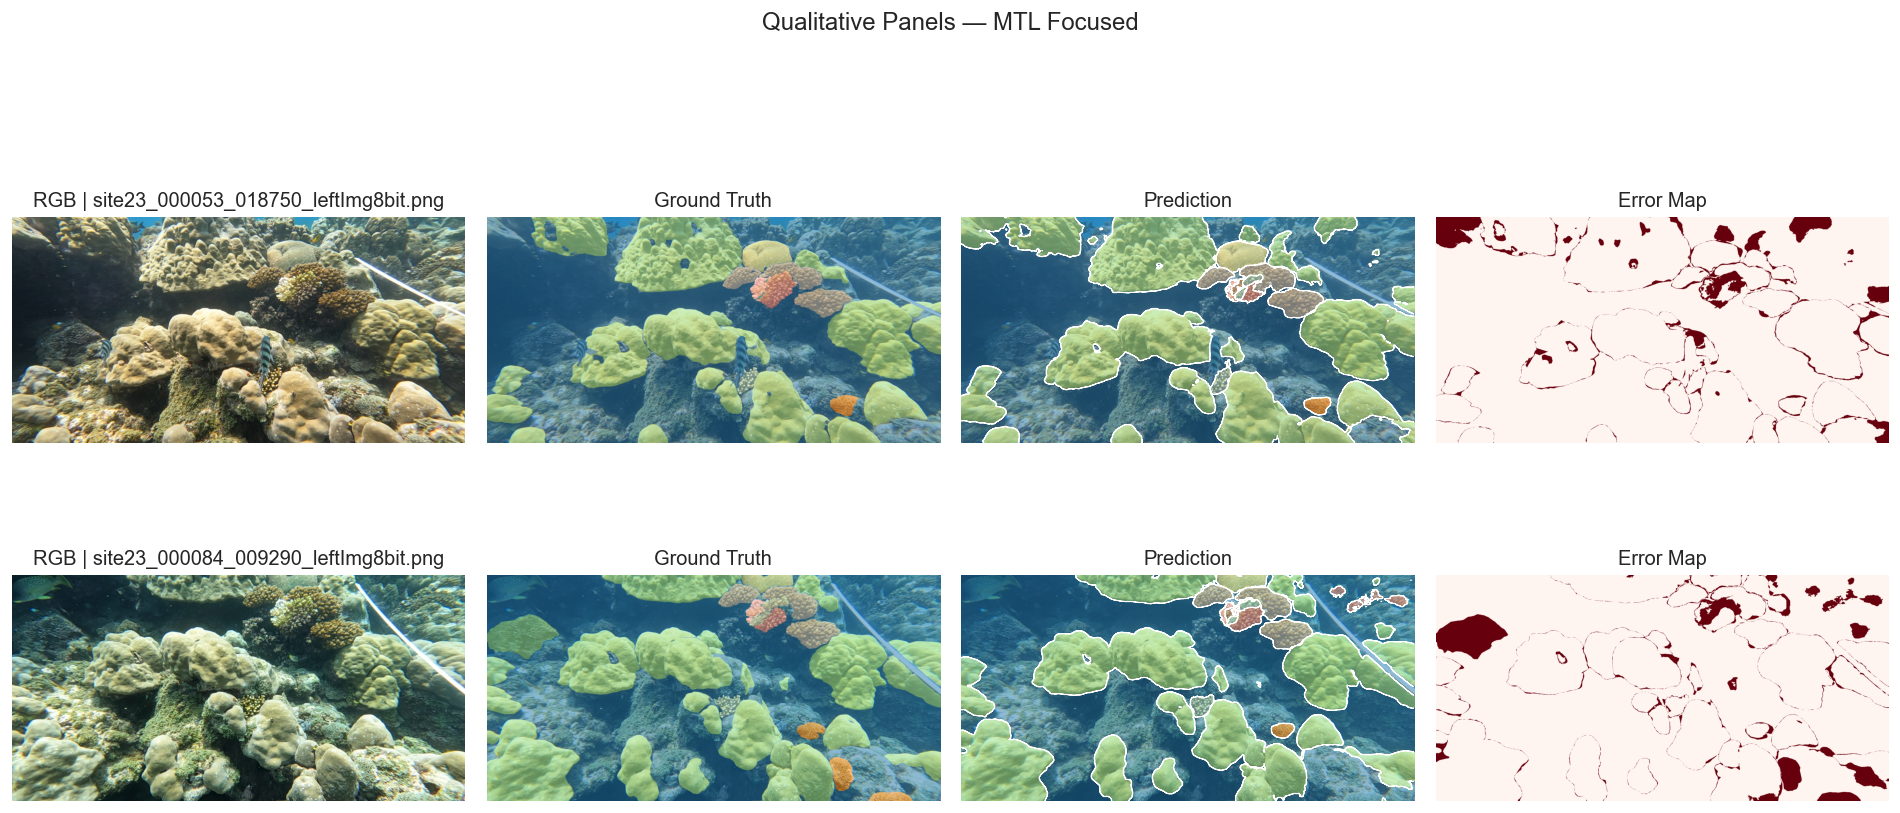

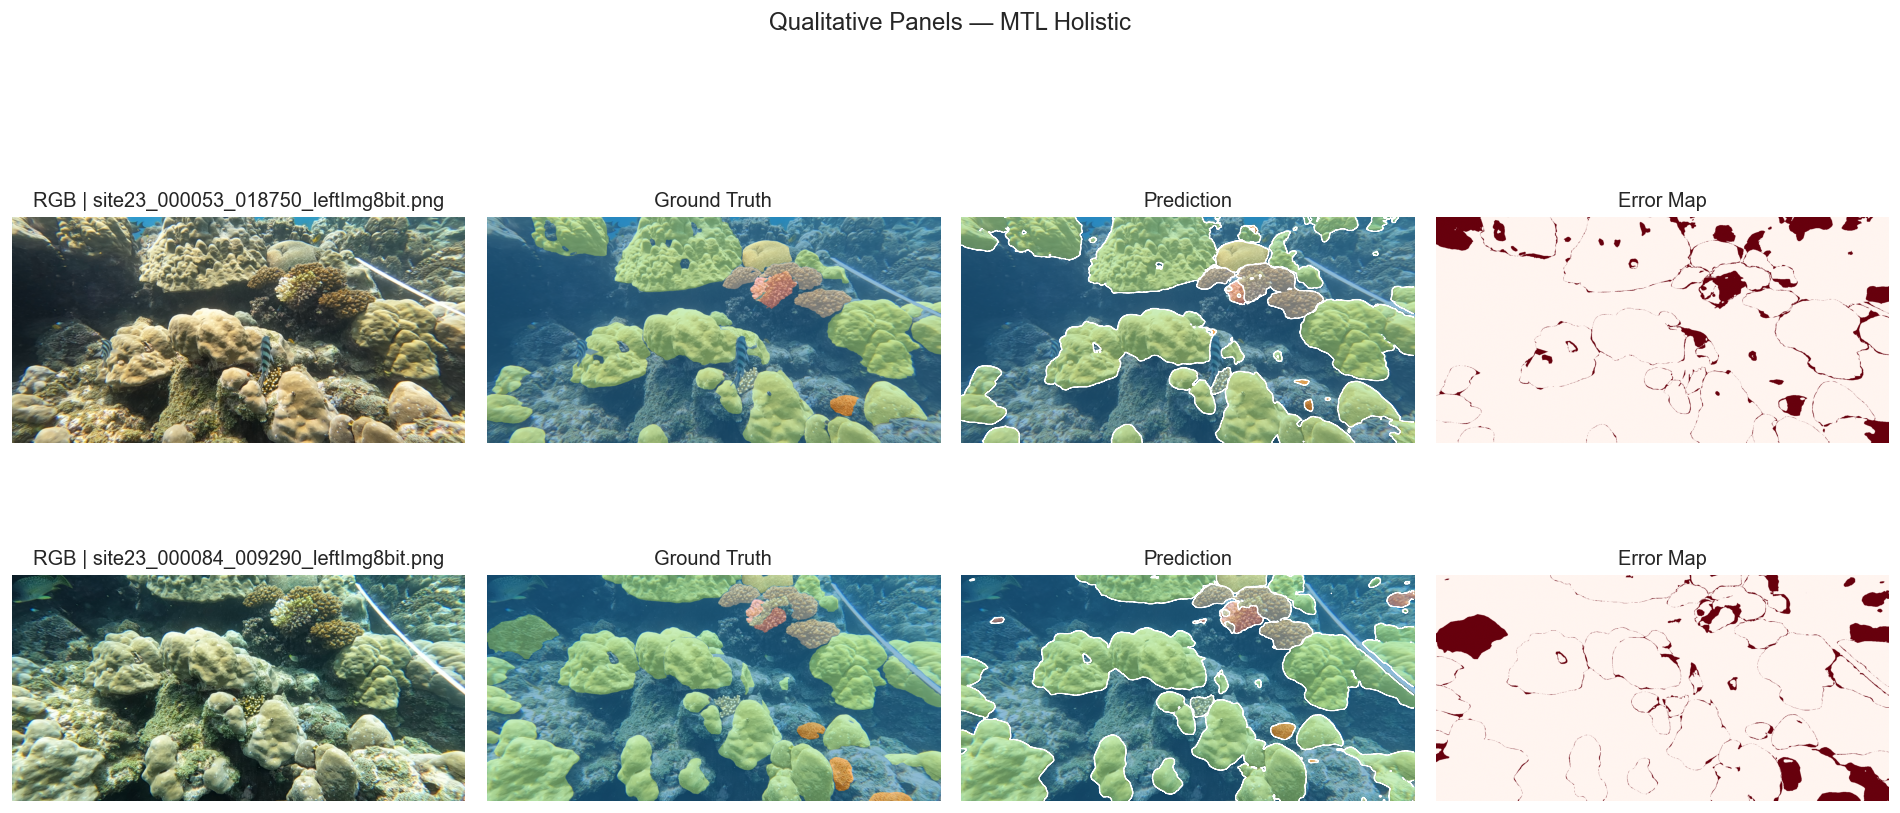

In [14]:
def plot_qualitative_panels(alias: str, panels: List[Dict[str, np.ndarray]], result: TaskInferenceResult, max_examples: int = 2) -> Optional[plt.Figure]:
    if not panels:
        return None
    examples = panels[:max_examples]
    lut = build_color_lut(result.label_names)
    fig, axes = plt.subplots(len(examples), 4, figsize=(16, 4 * len(examples)))
    if len(examples) == 1:
        axes = np.expand_dims(axes, axis=0)
    for row, panel in enumerate(examples):
        rgb = panel["rgb"]
        prediction = panel["prediction"]
        target = panel["target"]
        pred_rgb = mask_to_rgb(prediction, lut)
        gt_rgb = mask_to_rgb(target, lut)
        error_map = (prediction != target)

        axes[row, 0].imshow(rgb)
        axes[row, 0].set_title(f"RGB | {panel['image_id']}")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(rgb)
        axes[row, 1].imshow(gt_rgb, alpha=0.5)
        axes[row, 1].set_title("Ground Truth")
        axes[row, 1].axis("off")

        axes[row, 2].imshow(rgb)
        axes[row, 2].imshow(pred_rgb, alpha=0.5)
        if find_boundaries is not None:
            axes[row, 2].contour(find_boundaries(prediction, mode="outer"), colors="white", linewidths=0.6)
        axes[row, 2].set_title("Prediction")
        axes[row, 2].axis("off")

        axes[row, 3].imshow(error_map, cmap="Reds")
        axes[row, 3].set_title("Error Map")
        axes[row, 3].axis("off")

    fig.suptitle(f"Qualitative Panels — {display_names[alias]}")
    fig.tight_layout(rect=(0, 0, 1, 0.97))
    return fig


qualitative_figures = {}
for alias, panels in qualitative_panels.items():
    result = inference_results.get((alias, "genus"))
    if result is None:
        continue
    fig = plot_qualitative_panels(alias, panels, result, max_examples=settings.qualitative_samples)
    if fig is None:
        continue
    qualitative_figures[alias] = fig
    #export_figure(fig, f"qual_panels_{alias}")
qualitative_figures

C:\Users\20232788\AppData\Local\Temp\ipykernel_22128\919809884.py:14: UserWarning: The following kwargs were not used by contour: 'label'
  axes[1].contour(find_boundaries(target_mask, mode="outer"), colors="lime", linewidths=0.7, label="GT Boundary")
C:\Users\20232788\AppData\Local\Temp\ipykernel_22128\919809884.py:15: UserWarning: The following kwargs were not used by contour: 'label'
  axes[1].contour(find_boundaries(pred_mask, mode="outer"), colors="red", linewidths=0.7, label="Pred Boundary")


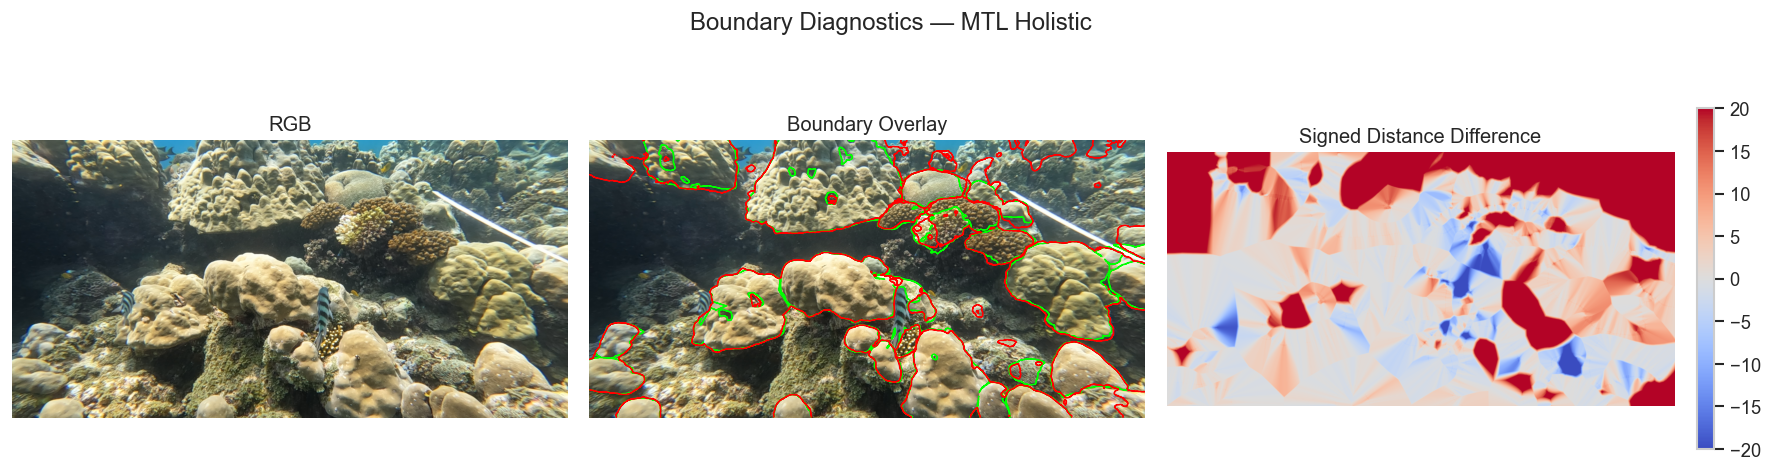

In [15]:
boundary_alias = "mtl_holistic"
boundary_panel = qualitative_panels[boundary_alias][0] if qualitative_panels[boundary_alias] else None
if boundary_panel is not None:
    pred_mask = boundary_panel["prediction"]
    target_mask = boundary_panel["target"]
    rgb = boundary_panel["rgb"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].imshow(rgb)
    axes[0].set_title("RGB")
    axes[0].axis("off")

    axes[1].imshow(rgb)
    if find_boundaries is not None:
        axes[1].contour(find_boundaries(target_mask, mode="outer"), colors="lime", linewidths=0.7, label="GT Boundary")
        axes[1].contour(find_boundaries(pred_mask, mode="outer"), colors="red", linewidths=0.7, label="Pred Boundary")
    axes[1].set_title("Boundary Overlay")
    axes[1].axis("off")

    if distance_transform_edt is not None:
        gt_binary = (target_mask != 0).astype(np.uint8)
        pred_binary = (pred_mask != 0).astype(np.uint8)
        gt_dist = distance_transform_edt(gt_binary) - distance_transform_edt(1 - gt_binary)
        pred_dist = distance_transform_edt(pred_binary) - distance_transform_edt(1 - pred_binary)
        diff_map = pred_dist - gt_dist
        im = axes[2].imshow(diff_map, cmap="coolwarm", vmin=-20, vmax=20)
        axes[2].set_title("Signed Distance Difference")
        axes[2].axis("off")
        fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    else:
        axes[2].imshow((pred_mask != target_mask), cmap="Reds")
        axes[2].set_title("Boundary Error (binary)")
        axes[2].axis("off")
    fig.suptitle("Boundary Diagnostics — MTL Holistic")
    fig.tight_layout(rect=(0, 0, 1, 0.93))
    #export_figure(fig, "boundary_diagnostic_holistic")
    fig
else:
    print("No qualitative panel available for boundary diagnostic.")

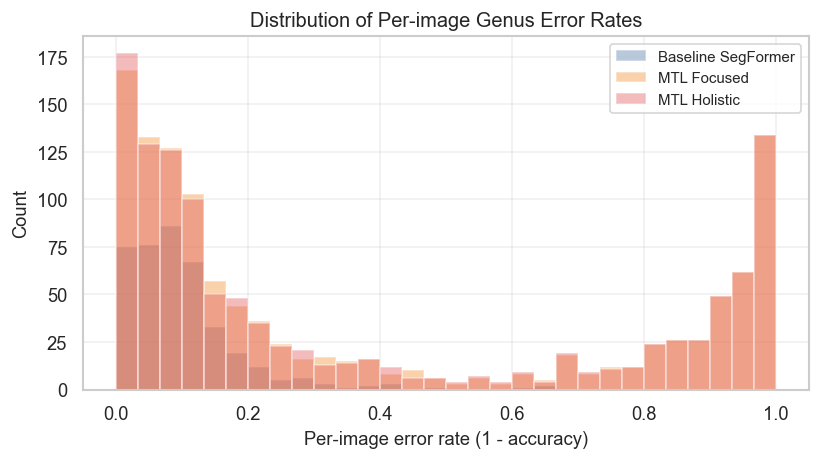

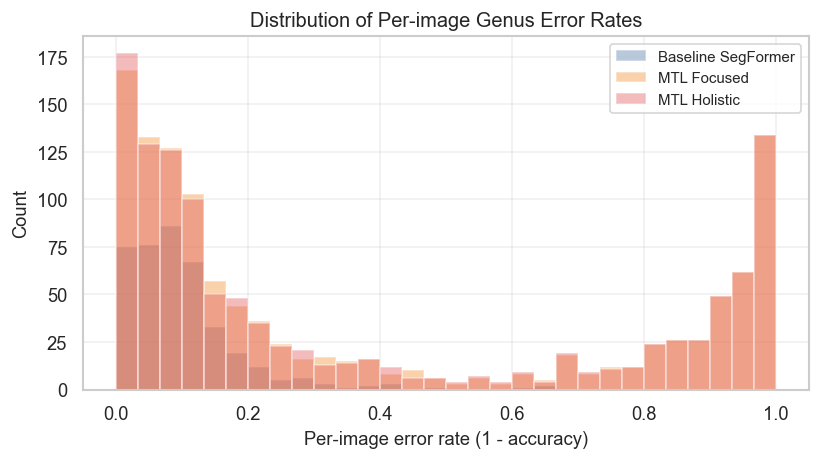

In [16]:
fig, ax = plt.subplots(figsize=(7, 4))
bins = np.linspace(0, 1, 31)
for alias, meta in experiments.items():
    cms_path = meta.artifacts.get("test_cms")
    if cms_path is None:
        continue
    df = compute_per_image_error_rates(cms_path)
    genus_errors = df[df["task"] == "genus"]["error_rate"]
    ax.hist(genus_errors, bins=bins, alpha=0.4, label=display_names[alias], color=palette[alias])
ax.set_xlabel("Per-image error rate (1 - accuracy)")
ax.set_ylabel("Count")
ax.set_title("Distribution of Per-image Genus Error Rates")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
#error_hist_paths = export_figure(fig, "per_image_error_distribution")
fig

In [ ]:
model_bundle_cache: Dict[str, Dict[str, object]] = {}
brightness_cache: Optional[Dict[str, float]] = None

def select_dominant_class(mask: np.ndarray) -> int:
    """Return the most frequent class id in a mask."""
    flat = np.asarray(mask).reshape(-1)
    if flat.size == 0:
        return 0
    values, counts = np.unique(flat, return_counts=True)
    return int(values[counts.argmax()])

def unnormalize_image(tensor: torch.Tensor) -> np.ndarray:
    """Undo standard ImageNet normalization for visualization."""
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
    image = torch.clamp(tensor * std + mean, 0.0, 1.0)
    return image.permute(1, 2, 0).cpu().numpy()

In [18]:
def collect_embeddings(
    alias: str,
    task_name: str,
    max_images: int = 64,
    target_image_ids: Optional[Iterable[str]] = None,
 ) -> Tuple[np.ndarray, np.ndarray, List[str], Optional[object]]:
    meta = experiments[alias]
    if not meta.config_path:
        raise ValueError(f"Experiment {alias} is missing its configuration path.")
    
    # Pass target_image_ids to build_inference_ready_config for dataset filtering
    config, fallback_used = build_inference_ready_config(
        Path(meta.config_path), 
        subset_image_ids=list(target_image_ids) if target_image_ids else None
    )
    
    factory = ExperimentFactory(config_dict=config)
    device = torch.device("cpu")
    model = factory.get_model()
    checkpoint_path = meta.artifacts.get("checkpoint")
    if checkpoint_path is None:
        raise FileNotFoundError(f"Missing checkpoint for experiment {alias}")
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    dataloaders = factory.get_dataloaders()
    loader = dataloaders.get("test") or dataloaders.get("validation")
    if loader is None:
        raise RuntimeError(f"No evaluation dataloader available for experiment {alias}")

    target_set: Optional[Set[str]] = None
    remaining_targets: Optional[Set[str]] = None
    if target_image_ids is not None:
        target_set = {str(identifier) for identifier in target_image_ids}
        remaining_targets = set(target_set)
        max_images = min(max_images, len(target_set))

    features: List[np.ndarray] = []
    labels: List[int] = []
    image_ids: List[str] = []
    collected = 0
    for batch_index, batch in enumerate(loader):
        if collected >= max_images:
            break
        images = batch["image"].to(device)
        with torch.no_grad():
            encoder_feats = model.encoder(images)
        pooled = F.adaptive_avg_pool2d(encoder_feats[-1], (1, 1)).squeeze(-1).squeeze(-1)
        if pooled.ndim == 1:
            pooled = pooled.unsqueeze(0)

        if "masks" in batch and task_name in batch["masks"]:
            mask_batch = batch["masks"][task_name].cpu().numpy()
        else:
            mask_batch = batch.get("mask")
            if mask_batch is None:
                raise KeyError(f"Batch missing masks for task '{task_name}'")
            mask_batch = mask_batch.cpu().numpy()

        ids = batch.get("image_id")
        if ids is None:
            ids = [f"{alias}_{batch_index}_{i}" for i in range(mask_batch.shape[0])]
        else:
            ids = [str(x) for x in ids]

        for sample_idx, image_id in enumerate(ids):
            if collected >= max_images:
                break
            if target_set is not None and image_id not in target_set:
                continue
            features.append(pooled[sample_idx : sample_idx + 1].cpu().numpy())
            labels.append(select_dominant_class(mask_batch[sample_idx]))
            image_ids.append(image_id)
            collected += 1
            if remaining_targets is not None:
                remaining_targets.discard(image_id)
        if target_set is not None and remaining_targets is not None and not remaining_targets:
            break

    if not features:
        targets_desc = f" for requested images {sorted(target_set)}" if target_set else ""
        loader_info = f"Processed {batch_index + 1} batches from loader."
        raise RuntimeError(
            f"No embeddings collected for experiment {alias}{targets_desc}. "
            f"{loader_info} Check that the dataset contains valid samples and task masks."
        )

    feature_matrix = np.concatenate(features, axis=0)[:max_images]
    label_array = np.asarray(labels[:max_images])
    selected_ids = image_ids[:max_images]
    
    print(f"[info] collect_embeddings: Collected {len(selected_ids)} samples, feature shape {feature_matrix.shape}")
    
    return feature_matrix, label_array, selected_ids, factory.task_splitter


[info] Extracting embeddings for top-16 images from full test dataset
--- Resolving relative paths from root: C:\Users\20232788\Desktop\Year3\dbl_capstone ---
Resolved task_definitions_path: configs/task_definitions.yaml -> C:\Users\20232788\Desktop\Year3\dbl_capstone\configs\task_definitions.yaml
Initialized TaskSplitter with 7 tasks and a unified global space of 40 classes.
--- Building model of type: CoralMTL ---


C:\Users\20232788\AppData\Local\Temp\ipykernel_22128\2530361965.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=de

--- Building dataloaders ---
Loading dataset from local file paths for split 'train'.
Loading 'train' split from prioritized PDS path: C:\Users\20232788\Desktop\Year3\dbl_capstone\tests\dataset\processed\pds_patches
Successfully loaded 4 samples for split 'train'.
Loading dataset from local file paths for split 'validation'.
Loading 'validation' split from data_root_path: C:\Users\20232788\Desktop\Year3\dbl_capstone\dataset\coralscapes
Successfully loaded 166 samples for split 'validation'.
[INFO] No target images found in validation split, skipping filter: No matching samples found for target image IDs: ['site1_000011_002112_leftImg8bit.png', 'site23_000100_003296_leftImg8bit.png', 'site1_000014_002382_leftImg8bit.png', 'site23_000001_020000_leftImg8bit.png', 'site22_000061_016633_leftImg8bit.png', 'site23_000107_011088_leftImg8bit.png', 'site22_000101_034765_leftImg8bit.png', 'site22_000109_013186_leftImg8bit.png', 'site23_000142_003296_leftImg8bit.png', 'site23_000102_000899_leftImg

c:\Users\20232788\AppData\Local\anaconda3\envs\dbl1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


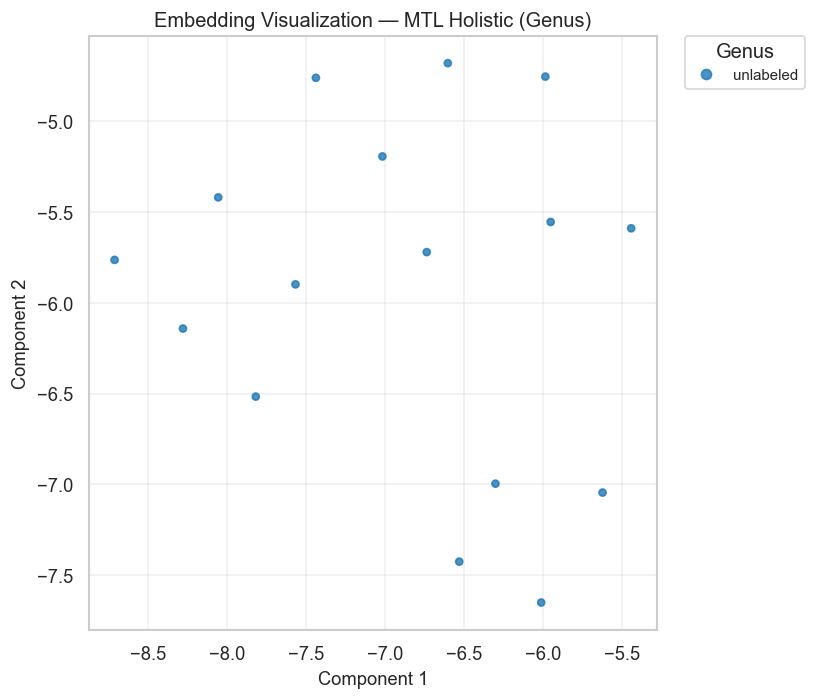

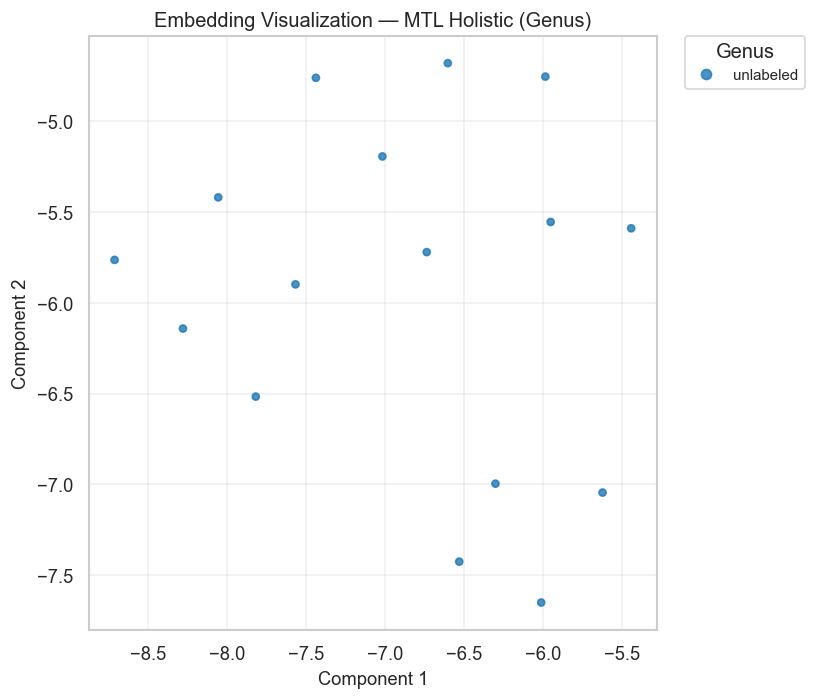

In [ ]:
# ==============================================================================
# Cell 20: Embedding Visualization with Dimensionality Reduction
# EXCLUDES unlabeled class (label 0) for cleaner visualization
# Uses UMAP (preferred) or t-SNE fallback
# ==============================================================================

# -------------------------------------------------------------------------
# Step 1: Select target images for embedding extraction
# -------------------------------------------------------------------------
# Only use target_image_ids if full test dataset is available (not fallback)
# When using fallback tests dataset, extract embeddings from whatever images are available
# Select a reproducible, limited subset of top-genus image ids from the middle-upper quartile.
# If no full test ranking is available, leave as None to trigger fallback behavior downstream.
if holistic_top_frame is None or holistic_top_frame.empty:
    embedding_target_ids = None
else:
    candidate_ids = holistic_top_frame["image_id"].tolist()
    n_pick = max(1, min(settings.max_samples_per_experiment, len(candidate_ids)))
    embedding_target_ids = candidate_ids[:n_pick]

if embedding_target_ids:
    print(f"[info] Extracting embeddings for top-{len(embedding_target_ids)} images from full test dataset")
    embedding_limit = len(embedding_target_ids)
else:
    print("[info] Extracting embeddings from available images (fallback dataset or no top_k selection)")
    embedding_limit = min(settings.qualitative_samples, 64)

embedding_limit = max(1, embedding_limit)

# -------------------------------------------------------------------------
# Step 2: Collect embeddings from encoder features
# -------------------------------------------------------------------------
embedding_features, embedding_labels, embedding_ids, splitter = collect_embeddings(
    "mtl_holistic",
    "genus",
    max_images=embedding_limit,
    target_image_ids=embedding_target_ids,
)

# Validate collected embeddings
print(f"[info] Collected {len(embedding_ids)} embeddings with shape {embedding_features.shape}")
if len(embedding_ids) == 0:
    raise RuntimeError("No embeddings were collected. Check dataset availability and target_image_ids.")

label_names_embedding = get_grouped_label_names(splitter, "genus")

# -------------------------------------------------------------------------
# Step 3: Filter out unlabeled class (class 0) for cleaner visualization
# -------------------------------------------------------------------------
unlabeled_class = 0
labeled_mask = embedding_labels != unlabeled_class

# Apply mask to filter out unlabeled samples
embedding_features_filtered = embedding_features[labeled_mask]
embedding_labels_filtered = embedding_labels[labeled_mask]
embedding_ids_filtered = [img_id for img_id, keep in zip(embedding_ids, labeled_mask) if keep]

print(f"[info] After filtering unlabeled class: {len(embedding_ids_filtered)} samples "
      f"(removed {(~labeled_mask).sum()} unlabeled samples)")

# Validate we still have enough samples for dimensionality reduction
n_samples = embedding_features_filtered.shape[0]
if n_samples < 2:
    raise RuntimeError(
        f"Insufficient labeled samples for dimensionality reduction: only {n_samples} sample(s) after filtering. "
        f"Try increasing the number of input images or check dataset quality."
    )

# -------------------------------------------------------------------------
# Step 4: Apply dimensionality reduction (UMAP or t-SNE)
# -------------------------------------------------------------------------
# Adjust hyperparameters based on filtered sample size
if umap is not None:
    # Ensure n_neighbors doesn't exceed sample count
    n_neighbors = min(15, max(2, n_samples - 1))
    print(f"[info] Using UMAP with n_neighbors={n_neighbors} for {n_samples} labeled samples")
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1, metric="cosine", random_state=42)
    embedding_2d = reducer.fit_transform(embedding_features_filtered)
    reducer_name = "UMAP"
else:
    # Ensure perplexity doesn't exceed (n_samples - 1) / 3
    perplexity = min(30, max(5, (n_samples - 1) // 3))
    print(f"[info] Using t-SNE with perplexity={perplexity} for {n_samples} labeled samples")
    embedding_2d = TSNE(
        n_components=2, 
        perplexity=perplexity, 
        learning_rate="auto", 
        init="pca", 
        random_state=42
    ).fit_transform(embedding_features_filtered)
    reducer_name = "t-SNE"

# -------------------------------------------------------------------------
# Step 5: Visualize embeddings with proper legend
# -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 6))

# Create scatter plot with filtered data
scatter = ax.scatter(
    embedding_2d[:, 0], 
    embedding_2d[:, 1], 
    c=embedding_labels_filtered, 
    cmap="tab20", 
    s=18, 
    alpha=0.8
)

# Build legend only for classes actually present in the filtered data
present_labels = np.unique(embedding_labels_filtered)
handles = []
legend_labels = []

# Create custom legend handles for present labels only
for label_idx in sorted(present_labels):
    if label_idx < len(label_names_embedding):
        # Create a dummy scatter point for legend
        handle = plt.scatter([], [], c=[scatter.cmap(scatter.norm(label_idx))], s=18)
        handles.append(handle)
        legend_labels.append(label_names_embedding[label_idx])

ax.legend(
    handles, 
    legend_labels, 
    title="Genus (Labeled Only)", 
    bbox_to_anchor=(1.05, 1), 
    loc="upper left", 
    borderaxespad=0.
)

ax.set_title(f"Embedding Visualization — MTL Holistic (Genus, {reducer_name})\nLabeled Classes Only (Excluding Background)")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.grid(True, alpha=0.3)
fig.tight_layout()

# Optionally export the figure
# embedding_paths = export_figure(fig, "embedding_scatter_genus_labeled_only", formats=("png", "pdf"))

fig

In [20]:
panel_lookup = {panel["image_id"]: panel for panel in qualitative_panels.get("mtl_holistic", [])}
usable_indices = [idx for idx, image_id in enumerate(embedding_ids) if image_id in panel_lookup]

if not usable_indices:
    print("[warn] No qualitative panels align with embedding image identifiers; montage skipped.")
elif not label_names_embedding:
    print("[warn] Label names unavailable; cannot generate cluster montage.")
else:
    feature_subset = embedding_features[usable_indices]
    id_subset = [embedding_ids[idx] for idx in usable_indices]
    label_subset = embedding_labels[usable_indices]
    num_clusters = min(12, len(id_subset))
    
    print(f"[info] Creating cluster montage with {len(id_subset)} samples, {num_clusters} clusters")
    
    if num_clusters >= 2:
        try:
            kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(feature_subset)
            fig_cols = min(4, num_clusters)
            fig_rows = math.ceil(num_clusters / fig_cols)
            fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(4 * fig_cols, 4 * fig_rows))
            axes = np.array(axes).reshape(-1)
            lut = build_color_lut(label_names_embedding)
            
            # Hide all axes first
            for ax in axes:
                ax.axis("off")
            
            # Populate cluster visualizations
            for cluster_idx in range(num_clusters):
                cluster_member_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_idx]
                if not cluster_member_indices:
                    print(f"[warn] Cluster {cluster_idx} has no members; skipping.")
                    continue
                
                centroid = kmeans.cluster_centers_[cluster_idx]
                best_member = min(
                    cluster_member_indices,
                    key=lambda i: np.linalg.norm(feature_subset[i] - centroid)
                )
                image_id = id_subset[best_member]
                
                # Validate panel exists
                if image_id not in panel_lookup:
                    print(f"[warn] Image {image_id} not found in panel_lookup; skipping cluster {cluster_idx}.")
                    continue
                
                panel = panel_lookup[image_id]
                rgb = panel["rgb"]
                pred_mask = panel["prediction"]
                overlay = mask_to_rgb(pred_mask, lut)
                
                axes[cluster_idx].imshow(rgb)
                axes[cluster_idx].imshow(overlay, alpha=0.45)
                
                # Compute majority label with bounds checking
                cluster_label_indices = label_subset[cluster_member_indices]
                majority_label = np.bincount(cluster_label_indices, minlength=len(label_names_embedding)).argmax()
                
                # Ensure majority_label is within bounds
                if majority_label >= len(label_names_embedding):
                    label_text = f"Unknown (class {majority_label})"
                else:
                    label_text = label_names_embedding[majority_label]
                
                axes[cluster_idx].set_title(
                    f"Cluster {cluster_idx + 1}\n{label_text}\n{image_id}",
                    fontsize=9
                )
                axes[cluster_idx].axis("off")
            
            fig.suptitle("Cluster Representatives — MTL Holistic Genus Embeddings")
            fig.tight_layout(rect=(0, 0, 1, 0.95))
            #cluster_paths = export_figure(fig, "cluster_montage_mtl_holistic_genus")
            fig
        except Exception as exc:
            print(f"[warn] Unable to form clusters for montage: {exc}")
            import traceback
            traceback.print_exc()
    else:
        # Single sample case - validate before accessing
        if len(id_subset) == 0 or len(label_subset) == 0:
            print("[warn] Insufficient data for single sample visualization.")
        else:
            image_id = id_subset[0]
            
            # Validate panel exists
            if image_id not in panel_lookup:
                print(f"[warn] Image {image_id} not found in panel_lookup; cannot create single sample visualization.")
            else:
                panel = panel_lookup[image_id]
                fig, ax = plt.subplots(figsize=(5, 5))
                lut = build_color_lut(label_names_embedding)
                overlay = mask_to_rgb(panel["prediction"], lut)
                ax.imshow(panel["rgb"])
                ax.imshow(overlay, alpha=0.45)
                
                # Validate label index
                label_idx = label_subset[0]
                if label_idx >= len(label_names_embedding):
                    label_name = f"Unknown (class {label_idx})"
                else:
                    label_name = label_names_embedding[label_idx]
                
                ax.set_title(f"Single Sample — {label_name}\n{image_id}")
                ax.axis("off")
                fig.tight_layout()
                #cluster_paths = export_figure(fig, "cluster_montage_mtl_holistic_genus_single")
                fig

[warn] No qualitative panels align with embedding image identifiers; montage skipped.


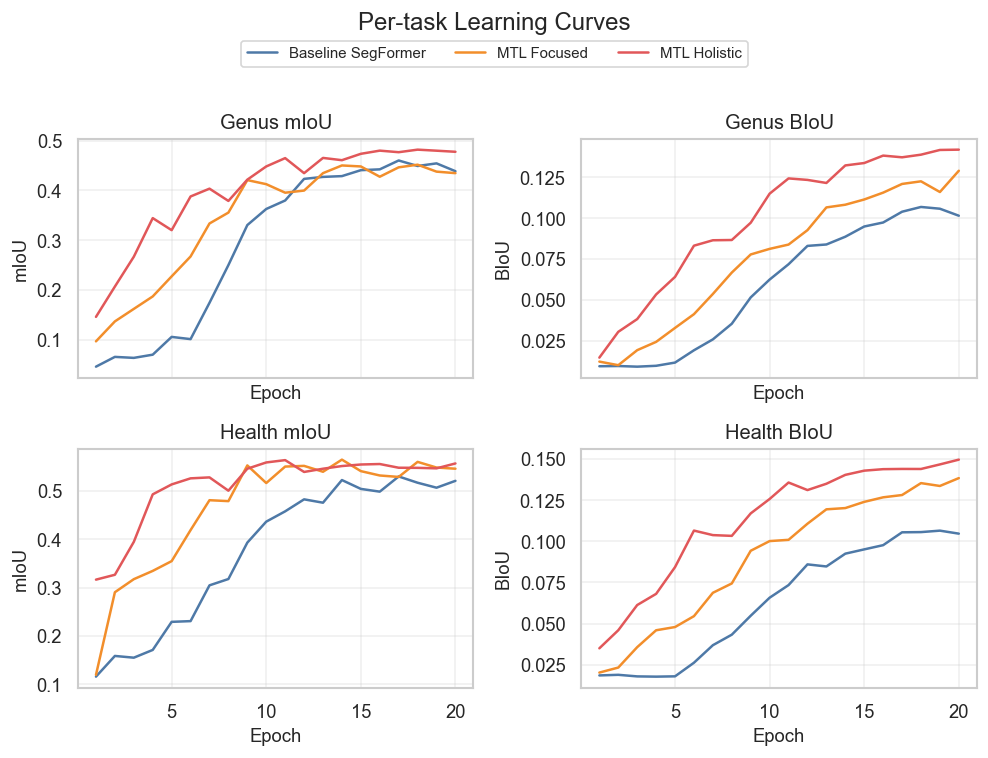

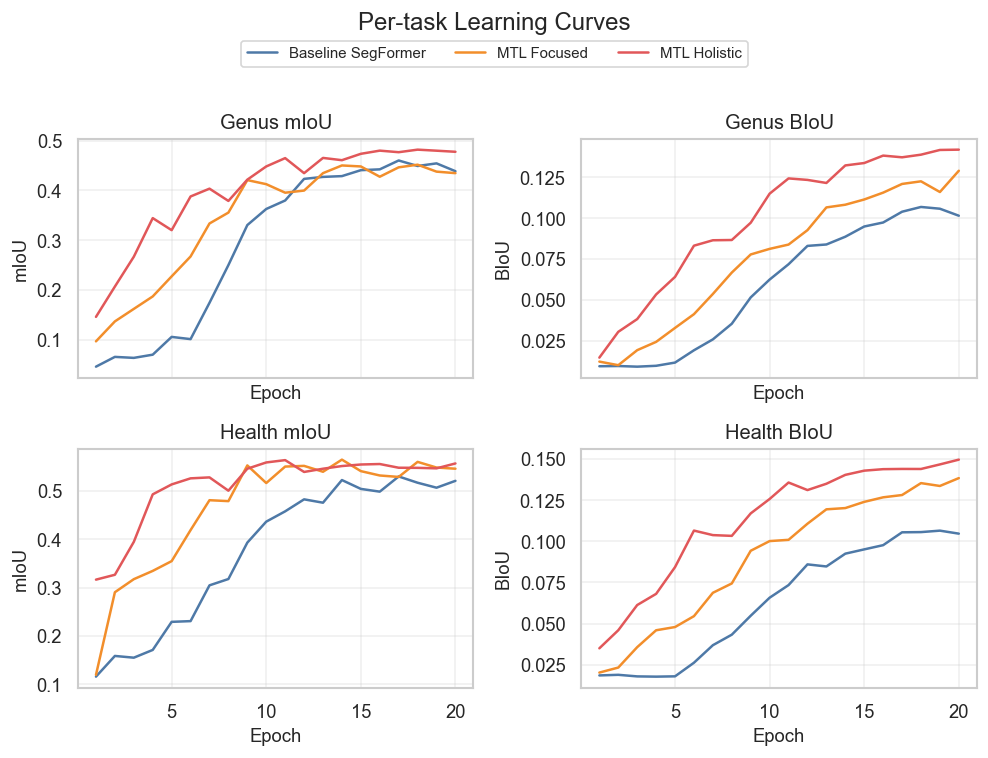

In [21]:
task_metric_groups = {
    "Genus": [
        ("tasks.genus.grouped.mIoU", "mIoU"),
        ("tasks.genus.grouped.BIoU", "BIoU"),
    ],
    "Health": [
        ("tasks.health.grouped.mIoU", "mIoU"),
        ("tasks.health.grouped.BIoU", "BIoU"),
    ],
}

max_columns = max(len(metrics) for metrics in task_metric_groups.values())
fig, axes = plt.subplots(len(task_metric_groups), max_columns, figsize=(4.2 * max_columns, 3.0 * len(task_metric_groups)), sharex=True)
if len(task_metric_groups) == 1:
    axes = np.array([axes])
axes = np.atleast_2d(axes)

for row_index, (task_label, metrics) in enumerate(task_metric_groups.items()):
    for col_index in range(max_columns):
        ax = axes[row_index, col_index]
        if col_index >= len(metrics):
            ax.set_visible(False)
            continue
        metric_key, short_label = metrics[col_index]
        plotted = False
        for alias, history in history_cache.items():
            series = extract_metric_series(history, metric_key)
            if series is None or series.empty:
                continue
            ax.plot(series["epoch"], series["value"], label=display_names[alias], color=palette[alias])
            plotted = True
        if not plotted:
            ax.set_visible(False)
            continue
        ax.set_title(f"{task_label} {short_label}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(short_label)
        ax.grid(True, alpha=0.3)

handles, labels = axes[0, 0].get_legend_handles_labels() if axes[0, 0].get_visible() else ([], [])
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=len(handles), bbox_to_anchor=(0.5, 1.02))
fig.suptitle("Per-task Learning Curves", y=1.05)
fig.tight_layout()
#per_task_curve_paths = export_figure(fig, "per_task_learning_curves", formats=("png", "pdf"))
fig

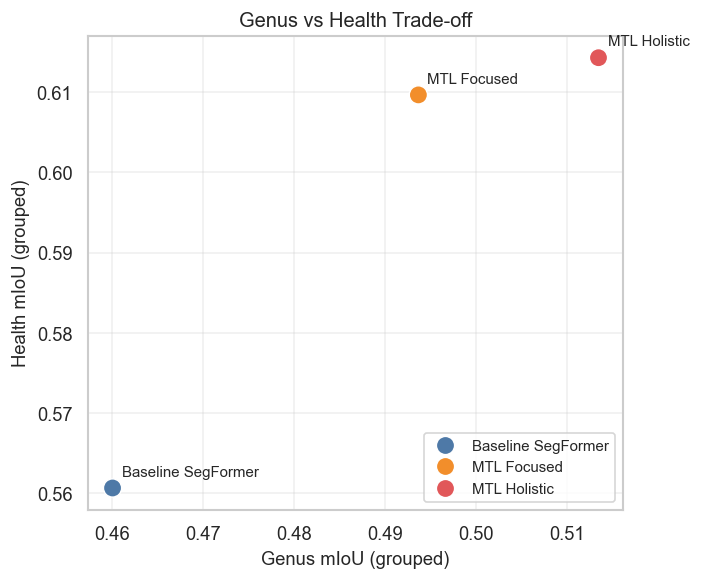

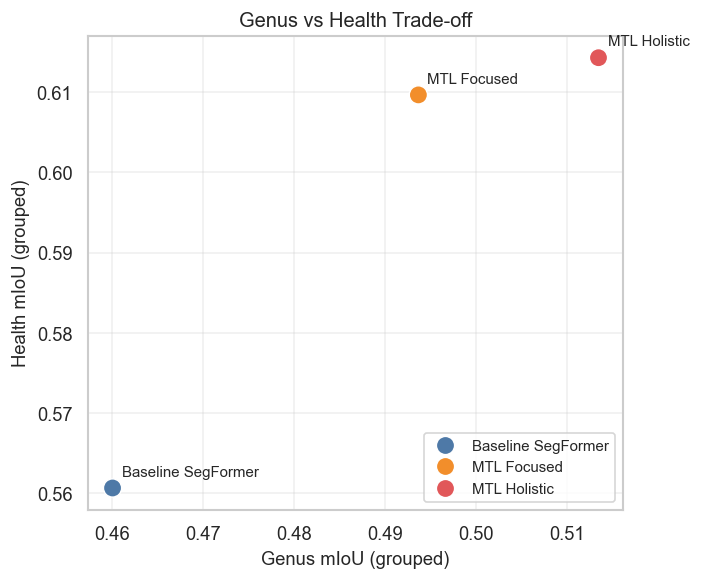

In [22]:
pareto_records: List[Dict[str, float]] = []
for alias, meta in experiments.items():
    metrics_dict = load_test_metrics(meta)
    genus_summary = extract_task_summary(metrics_dict, task="genus", level="grouped")
    health_summary = extract_task_summary(metrics_dict, task="health", level="grouped")
    if genus_summary.empty or health_summary.empty:
        continue
    pareto_records.append({
        "Model": display_names[alias],
        "Genus mIoU": float(genus_summary.get("mIoU", np.nan)),
        "Health mIoU": float(health_summary.get("mIoU", np.nan)),
        "Genus BIoU": float(genus_summary.get("BIoU", np.nan)),
        "Health BIoU": float(health_summary.get("BIoU", np.nan)),
    })

pareto_df = pd.DataFrame(pareto_records).dropna(subset=["Genus mIoU", "Health mIoU"])
fig, ax = plt.subplots(figsize=(6, 5))
if pareto_df.empty:
    ax.set_axis_off()
    ax.text(0.5, 0.5, "No task summaries available", ha="center", va="center")
else:
    sns.scatterplot(data=pareto_df, x="Genus mIoU", y="Health mIoU", hue="Model", palette=model_palette, s=120, ax=ax)
    for _, row in pareto_df.iterrows():
        ax.text(row["Genus mIoU"] + 0.001, row["Health mIoU"] + 0.0015, row["Model"], fontsize=9)
    ax.set_xlabel("Genus mIoU (grouped)")
    ax.set_ylabel("Health mIoU (grouped)")
    ax.set_title("Genus vs Health Trade-off")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="lower right")
fig.tight_layout()
#pareto_paths = export_figure(fig, "pareto_genus_health", formats=("png", "pdf"))
fig

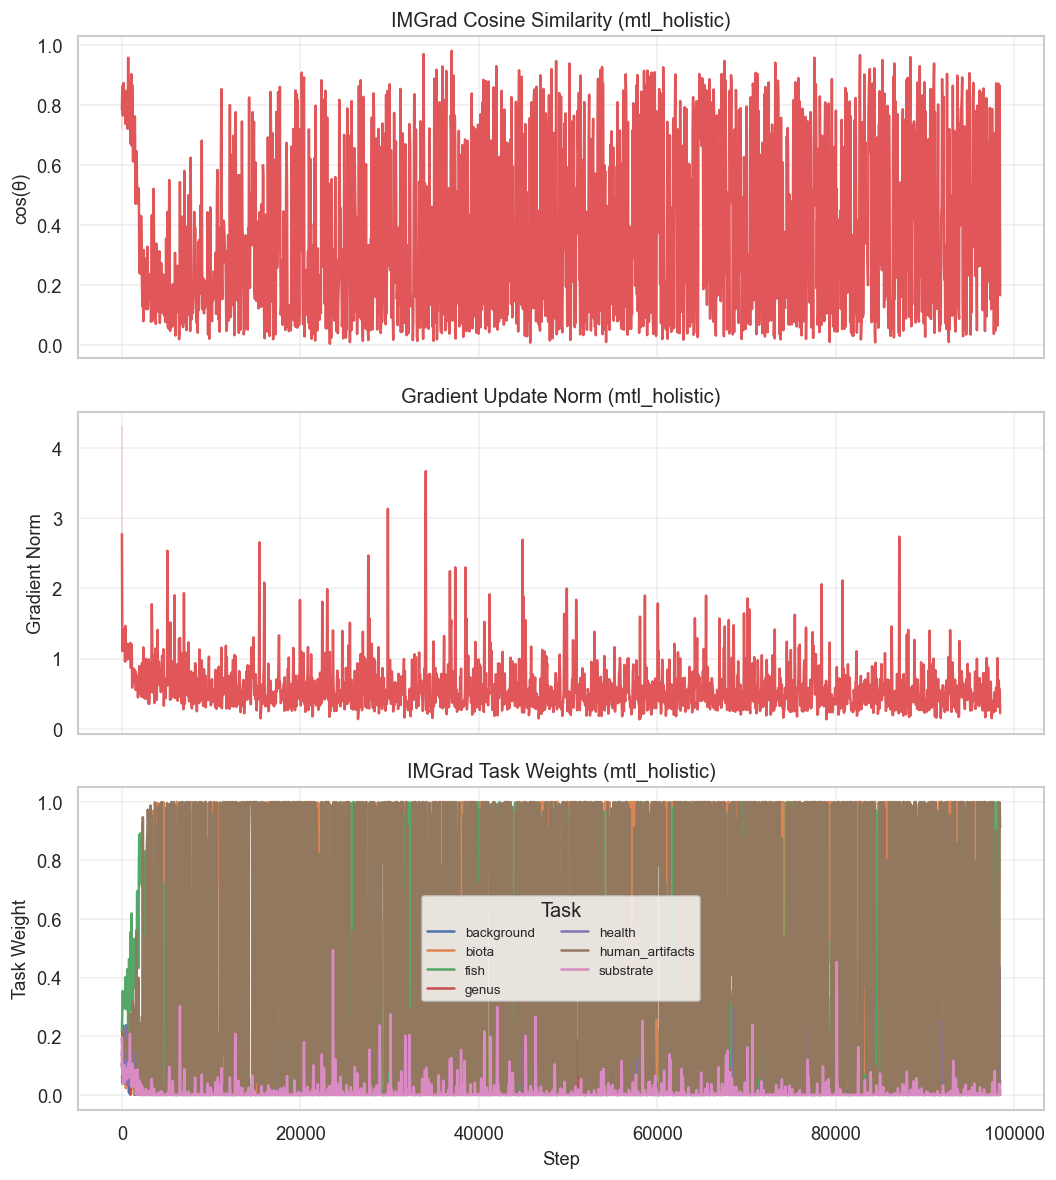

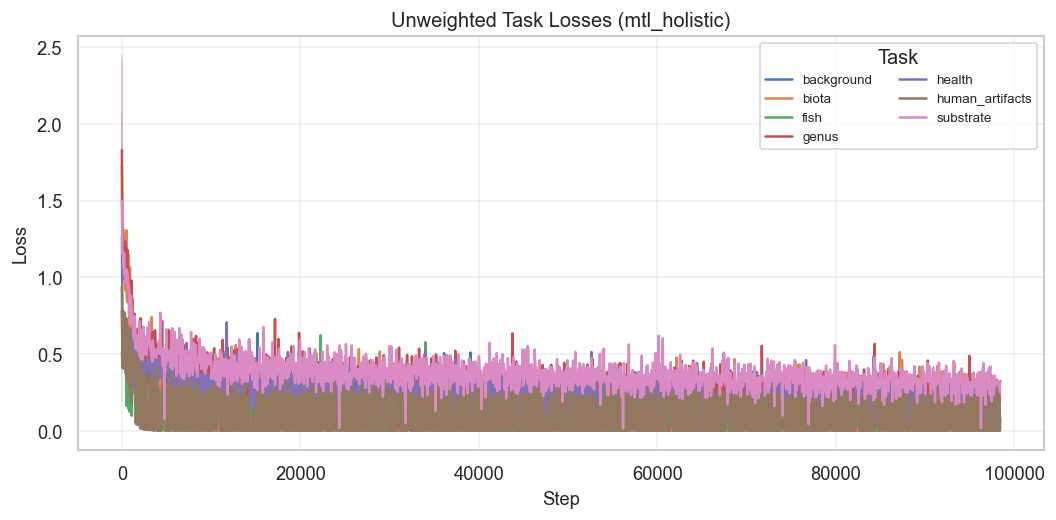

: 

In [ ]:
def load_imgrad_diagnostics(meta: ExperimentMetadata) -> pd.DataFrame:
    diagnostics_path = meta.artifacts.get("loss_diagnostics")
    if diagnostics_path is None or not diagnostics_path.exists():
        return pd.DataFrame()
    records: List[Dict[str, float]] = []
    with diagnostics_path.open("r", encoding="utf-8") as handle:
        for line in handle:
            if not line.strip():
                continue
            payload = json.loads(line)
            if payload.get("strategy_type") != "IMGradStrategy":
                continue
            record: Dict[str, float] = {
                "step": payload.get("step"),
                "epoch": payload.get("epoch"),
                "imgrad_cos_theta": payload.get("imgrad_cos_theta"),
                "gradient_update_norm": payload.get("gradient_update_norm"),
            }
            for task_name, value in payload.get("unweighted_losses", {}).items():
                record[f"loss_{task_name}"] = float(value)
            for task_name, value in payload.get("task_weights", {}).items():
                record[f"weight_{task_name}"] = float(value)
            records.append(record)
    return pd.DataFrame.from_records(records)

imgrad_alias = "mtl_holistic"
imgrad_meta = experiments.get(imgrad_alias)
imgrad_df = load_imgrad_diagnostics(imgrad_meta) if imgrad_meta else pd.DataFrame()
if imgrad_df.empty:
    print("[info] No IMGrad diagnostics found for mtl_holistic.")
else:
    imgrad_df = imgrad_df.sort_values(["epoch", "step"]).reset_index(drop=True)
    weight_cols = sorted(col for col in imgrad_df.columns if col.startswith("weight_"))
    loss_cols = sorted(col for col in imgrad_df.columns if col.startswith("loss_"))
    fig, axes = plt.subplots(3, 1, figsize=(9, 10), sharex=True)

    sns.lineplot(data=imgrad_df, x="step", y="imgrad_cos_theta", ax=axes[0], color=palette[imgrad_alias])
    axes[0].set_ylabel("cos(θ)")
    axes[0].set_title("IMGrad Cosine Similarity (mtl_holistic)")
    axes[0].grid(True, alpha=0.3)

    sns.lineplot(data=imgrad_df, x="step", y="gradient_update_norm", ax=axes[1], color=palette[imgrad_alias])
    axes[1].set_ylabel("Gradient Norm")
    axes[1].set_title("Gradient Update Norm (mtl_holistic)")
    axes[1].grid(True, alpha=0.3)

    if weight_cols:
        for col in weight_cols:
            task_label = col.replace("weight_", "")
            sns.lineplot(data=imgrad_df, x="step", y=col, ax=axes[2], label=task_label)
        axes[2].set_ylabel("Task Weight")
        axes[2].legend(title="Task", ncol=2, fontsize=8)
    axes[2].set_xlabel("Step")
    axes[2].grid(True, alpha=0.3)
    axes[2].set_title("IMGrad Task Weights (mtl_holistic)")

    fig.tight_layout()
    #export_figure(fig, "imgrad_diagnostics_mtl_holistic", formats=("png", "pdf"))
    fig

    if loss_cols:
        fig_losses, ax_losses = plt.subplots(figsize=(9, 4.5))
        for col in loss_cols:
            task_label = col.replace("loss_", "")
            sns.lineplot(data=imgrad_df, x="step", y=col, ax=ax_losses, label=task_label)
        ax_losses.set_title("Unweighted Task Losses (mtl_holistic)")
        ax_losses.set_xlabel("Step")
        ax_losses.set_ylabel("Loss")
        ax_losses.grid(True, alpha=0.3)
        ax_losses.legend(title="Task", ncol=2, fontsize=8)
        fig_losses.tight_layout()
        #export_figure(fig_losses, "imgrad_unweighted_losses_mtl_holistic", formats=("png", "pdf"))
        fig_losses

    display_columns = ["step", "epoch", "imgrad_cos_theta", "gradient_update_norm"] + weight_cols + loss_cols
    tail_preview = imgrad_df[display_columns].tail(5).copy()
    tail_preview

In [ ]:
# ==============================================================================
# Cell 25: Task-Conditioned Attribution Maps (Saliency Visualization)
# Uses ONLY the first top-performing genus image from holistic_top_frame
# ==============================================================================

attribution_alias = "mtl_holistic" if "mtl_holistic" in experiments else next(iter(experiments.keys()))
preferred_tasks = ["genus", "health"]

# -------------------------------------------------------------------------
# Step 1: Select the single best genus image for attribution analysis
# -------------------------------------------------------------------------
attribution_target_id = None
if holistic_top_frame is not None and not holistic_top_frame.empty:
    attribution_target_id = holistic_top_frame["image_id"].iloc[0]
    print(f"[info] Attribution analysis on single top-performing image: {attribution_target_id}")
else:
    print("[info] No top_frame available, will use first available image")

# -------------------------------------------------------------------------
# Step 2: Load model with filtered dataset (single image only)
# -------------------------------------------------------------------------
meta = experiments[attribution_alias]
if not meta.config_path:
    raise ValueError(f"Experiment {attribution_alias} is missing configuration path.")

# Build config with single-image filtering
config, fallback_used = build_inference_ready_config(
    Path(meta.config_path),
    subset_image_ids=[attribution_target_id] if attribution_target_id else None
)

# Initialize factory with filtered config
factory = ExperimentFactory(config_dict=config)
device = torch.device("cpu")

# Load model with checkpoint
model = factory.get_model()
checkpoint_path = meta.artifacts.get("checkpoint")
if checkpoint_path is None:
    raise FileNotFoundError(f"Checkpoint unavailable for experiment {meta.name}.")

state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# Get filtered dataloader
dataloaders = factory.get_dataloaders()
loader = dataloaders.get("test") or dataloaders.get("validation")
if loader is None:
    raise RuntimeError(f"No evaluation dataloader for experiment {meta.name}.")

dataset = loader.dataset
if len(dataset) == 0:
    raise RuntimeError(
        f"Filtered dataset is empty. Image {attribution_target_id} may not exist in the dataset."
    )

print(f"[info] Attribution dataset contains {len(dataset)} sample(s)")

# -------------------------------------------------------------------------
# Step 3: Load the single sample and prepare for gradient computation
# -------------------------------------------------------------------------
sample = dataset[0]
image_tensor = sample["image"].unsqueeze(0).to(device).requires_grad_(True)
task_masks = sample.get("masks")
if task_masks is None:
    raise RuntimeError("Dataset sample does not expose per-task masks for attribution analysis.")

# -------------------------------------------------------------------------
# Step 4: Forward pass to get task outputs
# -------------------------------------------------------------------------
with torch.enable_grad():
    outputs = model(image_tensor)

tasks_to_visualize = [task for task in preferred_tasks if task in outputs and task in task_masks]
if not tasks_to_visualize:
    tasks_to_visualize = [next(iter(outputs.keys()))]

# -------------------------------------------------------------------------
# Step 5: Compute saliency maps via gradient-based attribution
# -------------------------------------------------------------------------
saliency_maps: Dict[str, np.ndarray] = {}
dominant_indices: Dict[str, int] = {}
dominant_labels: Dict[str, str] = {}
task_splitter = getattr(factory, "task_splitter", None)

for task_position, task_name in enumerate(tasks_to_visualize):
    logits = outputs.get(task_name)
    mask_tensor = task_masks.get(task_name)
    if logits is None or mask_tensor is None:
        continue
    
    # Find dominant class in ground truth mask
    mask_np = mask_tensor.cpu().numpy()
    class_idx = select_dominant_class(mask_np)
    dominant_indices[task_name] = class_idx
    
    # Compute gradient w.r.t. dominant class score
    score = logits[:, class_idx].mean()
    model.zero_grad()
    if image_tensor.grad is not None:
        image_tensor.grad.zero_()
    
    # Backward pass (retain graph for all but last task)
    score.backward(retain_graph=task_position < len(tasks_to_visualize) - 1)
    
    # Extract and normalize gradient as saliency map
    gradient = image_tensor.grad.detach().abs().max(dim=1)[0].cpu().numpy()[0]
    if image_tensor.grad is not None:
        image_tensor.grad.zero_()
    
    gradient -= gradient.min()
    if gradient.max() > 0:
        gradient /= gradient.max()
    
    saliency_maps[task_name] = gradient
    
    # Resolve class label name if possible
    if task_splitter is not None:
        try:
            label_names = get_ungrouped_label_names(task_splitter, task_name)
            if 0 <= class_idx < len(label_names):
                dominant_labels[task_name] = label_names[class_idx]
        except Exception:
            pass

# -------------------------------------------------------------------------
# Step 6: Visualize RGB input + task-specific saliency overlays
# -------------------------------------------------------------------------
rgb_image = unnormalize_image(sample["image"])
fig, axes = plt.subplots(
    1, 
    len(tasks_to_visualize) + 1, 
    figsize=(5 * (len(tasks_to_visualize) + 1), 4.5)
)
axes = np.atleast_1d(axes)

# First panel: original RGB image
axes[0].imshow(rgb_image)
axes[0].set_title(f"Input RGB — {sample.get('image_id', 'sample')}")
axes[0].axis("off")

# Subsequent panels: RGB + task-specific saliency overlay
for position, task_name in enumerate(tasks_to_visualize, start=1):
    ax = axes[position]
    ax.imshow(rgb_image)
    saliency = saliency_maps.get(task_name)
    if saliency is not None:
        ax.imshow(saliency, cmap="magma", alpha=0.6)
    
    # Build title with task name and dominant class
    label_desc = dominant_labels.get(task_name) or f"class {dominant_indices.get(task_name, 0)}"
    ax.set_title(f"{task_name.title()} focus\n{label_desc}")
    ax.axis("off")

# Hide unused subplots
for ax in axes[len(tasks_to_visualize) + 1:]:
    ax.set_visible(False)

fig.tight_layout()
# attribution_paths = export_figure(fig, "task_conditioned_attributions", formats=("png", "pdf"))
fig

--- Resolving relative paths from root: C:\Users\20232788\Desktop\Year3\dbl_capstone ---
Resolved task_definitions_path: configs/task_definitions.yaml -> C:\Users\20232788\Desktop\Year3\dbl_capstone\configs\task_definitions.yaml
Initialized TaskSplitter with 7 tasks and a unified global space of 40 classes.
--- Building model of type: CoralMTL ---


C:\Users\20232788\AppData\Local\Temp\ipykernel_22128\311062259.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=dev

--- Building dataloaders ---
Loading dataset from local file paths for split 'train'.
Loading 'train' split from prioritized PDS path: C:\Users\20232788\Desktop\Year3\dbl_capstone\tests\dataset\processed\pds_patches
Successfully loaded 4 samples for split 'train'.
Loading dataset from local file paths for split 'validation'.
Loading 'validation' split from data_root_path: C:\Users\20232788\Desktop\Year3\dbl_capstone\dataset\coralscapes
Successfully loaded 166 samples for split 'validation'.
Loading dataset from local file paths for split 'test'.
Loading 'test' split from data_root_path: C:\Users\20232788\Desktop\Year3\dbl_capstone\dataset\coralscapes
Successfully loaded 392 samples for split 'test'.


## Architecture Diagram — Baseline vs MTL Focused vs MTL Holistic

Generate a side-by-side architecture confrontation diagram showing the structural differences between the three model variants.

In [ ]:
if __name__ == "__main__":
    from utils.architecture_diagram import GRAPHVIZ_AVAILABLE, export_architecture_diagram, export_feature_exchange_diagram
    if not GRAPHVIZ_AVAILABLE:
        print("[ERROR] Graphviz not available. Install with: pip install graphviz")
        print("        On Windows: pip install graphviz")
        print("        Also ensure Graphviz system binaries are installed:")
        print("        https://graphviz.org/download/")
        exit(1)
    
    print("=" * 70)
    print("Generating Enhanced Architecture Diagrams")
    print("=" * 70)
    
    # Main comparison diagram
    print("\n[1/2] Architecture Comparison Diagram")
    print("      Shows complete pipeline for all three models:")
    print("      • Baseline: Standard MLP decoder with single global head (39 classes)")
    print("      • MTL Focused: 2 primary + 5 auxiliary tasks with cross-attention")
    print("      • MTL Holistic: 7 primary tasks with full mutual cross-attention")
    print("      • Feature exchange mechanisms (Q/K/V projections, attention, gating)")
    print("      • Decoder architecture differences (MLP vs hierarchical streams)")
    
    try:
        paths = export_architecture_diagram()
        print("\n      ✓ Exported to:")
        for fmt, path in paths.items():
            print(f"          {fmt.upper():4s}: {path}")
    except Exception as e:
        print(f"\n      ✗ Error: {e}")
        import traceback
        traceback.print_exc()
        exit(1)
    
    # Feature exchange detail diagram
    print("\n" + "-" * 70)
    print("\n[2/2] Feature Exchange Detail Diagram")
    print("      Shows detailed cross-attention mechanism:")
    print("      • Context pooling (4×4 AvgPool)")
    print("      • Q/K/V projections (1×1 Conv, dim=128)")
    print("      • Scaled dot-product attention computation")
    print("      • MLP projection back to feature space")
    print("      • Gating mechanism for adaptive fusion")
    
    try:
        paths = export_feature_exchange_diagram()
        print("\n      ✓ Exported to:")
        for fmt, path in paths.items():
            print(f"          {fmt.upper():4s}: {path}")
    except Exception as e:
        print(f"\n      ✗ Error: {e}")
        import traceback
        traceback.print_exc()
        exit(1)
    
    print("\n" + "=" * 70)
    print("✓ All diagrams generated successfully!")
    print("=" * 70)


Generating Enhanced Architecture Diagrams

[1/2] Architecture Comparison Diagram
      Shows complete pipeline for all three models:
      • Baseline: Standard MLP decoder with single global head (39 classes)
      • MTL Focused: 2 primary + 5 auxiliary tasks with cross-attention
      • MTL Holistic: 7 primary tasks with full mutual cross-attention
      • Feature exchange mechanisms (Q/K/V projections, attention, gating)
      • Decoder architecture differences (MLP vs hierarchical streams)

      ✓ Exported to:
          PNG : C:\Users\20232788\Desktop\Year3\dbl_capstone\latex\Poster_Data_shallange\Result-figures\architecture_comparison.png
          PDF : C:\Users\20232788\Desktop\Year3\dbl_capstone\latex\Methodology\Result-figures\architecture_comparison.pdf
          SVG : C:\Users\20232788\Desktop\Year3\dbl_capstone\latex\Methodology\Result-figures\architecture_comparison.svg

----------------------------------------------------------------------

[2/2] Feature Exchange Detail D